## **Практическая работа №3**

### Вариант 8

Таблица находится в конце файла. Так же все файлы проекта (в том числе отчёт в формате odt или pdf) можно скачать с git: https://git.dm1sh.ru/data-visualization/practice3

Изначально проект писался в vscode под линуксом, если не работает установка пакетов в первом блоке, попробуйте заменить % на ! или установить пакеты вручную и удалить его

1. Подгружаем нужные для работы пакеты

In [225]:
# установка matplotlib, numpy и pandas
%pip install matplotlib numpy pandas seaborn scikit-learn ChernoffFace --upgrade


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [226]:
%matplotlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

from ChernoffFace import *
import matplotlib.cm

from IPython.display import display, Markdown

plt.rcParams['figure.dpi'] = 300

Using matplotlib backend: agg


2. Загружаем данные. Они представляют сведения об системе отопления и вентиляции (HVAC). Данные записывались в течение 14 дней, каждые 5 минут. Некоторые дни характеризуются аномальным поведением системы из-за неправильных настроек, которые привели к сбоям в работе системы. Задача: определить, в какие дни возникали аномальные ситуации в системе тепловентилирования и кондиционирования, какие параметры связаны с аномалиями.

- Загрузим файл с исходными данными и выберем те столбцы, исследование которых предполагается вариантом, для удобства переименовав их. 

In [227]:
df_full = pd.read_csv('./data/bldg-MC2.csv').astype({'Date/Time': 'datetime64'})

keys = filter(lambda x: 'F_3_Z_8' in x, df_full.keys())
df_orig = df_full[[*keys, "Date/Time"]]

def remove_id(key: str):
    if key == "Date/Time":
        return key
    
    return " ".join(key.split()[1:])

df_orig = df_orig.rename(columns=remove_id)

display(df_orig.info())
display(df_orig.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Lights Power                     4032 non-null   float64       
 1   Equipment Power                  4032 non-null   float64       
 2   Thermostat Temp                  4032 non-null   float64       
 3   Thermostat Heating Setpoint      4032 non-null   float64       
 4   Thermostat Cooling Setpoint      4032 non-null   float64       
 5   VAV REHEAT Damper Position       4032 non-null   float64       
 6   REHEAT COIL Power                4032 non-null   float64       
 7   RETURN OUTLET CO2 Concentration  4032 non-null   float64       
 8   SUPPLY INLET Temperature         4032 non-null   float64       
 9   SUPPLY INLET Mass Flow Rate      4032 non-null   float64       
 10  Date/Time                        4032 non-null   datetime64[

None

Lights Power  Equipment Power  Thermostat Temp  \
count   4032.000000      4032.000000      4032.000000   
mean     382.896577       382.361052        24.265656   
std      559.264492       313.188071         2.263242   
min        0.000000       167.939000        18.324200   
25%        0.000000       167.939000        24.000100   
50%        0.000000       167.939000        24.001100   
75%     1199.564100       839.694800        24.001600   
max     1199.564100       839.694800        32.224500   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                  4032.000000                  4032.000000   
mean                     21.772634                    24.875164   
std                       4.224116                     3.419606   
min                      12.600000                    15.560000   
25%                      21.000000                    24.000000   
50%                      21.000000                    24.000000   
75%                      24.000000                    25.875000   
max                      32.220000                    35.200000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                 4032.000000        4032.000000   
mean                     0.605345        1694.379812   
std                      0.357680        2180.469786   
min                      0.200000           0.000000   
25%                      0.200000           0.000000   
50%                      0.544850           0.000000   
75%                      1.000000        4222.009550   
max                      1.000000       12087.365100   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                      4032.000000               4032.000000   
mean                        597.874086                 16.995249   
std                         239.041545                  5.796048   
min                         401.408000                 12.280600   
25%                         421.000550                 12.800200   
50%                         494.879500                 12.801900   
75%                         686.973925                 21.618925   
max                        1448.366100                 40.041300   

       SUPPLY INLET Mass Flow Rate  
count                  4032.000000  
mean                      0.301222  
std                       0.175148  
min                       0.098800  
25%                       0.098800  
50%                       0.270600  
75%                       0.493900  
max                       0.493900

- Разделим данные на дни

In [228]:
dfs = [df for _, df in df_orig.groupby(df_orig["Date/Time"].dt.date)]

dfs = list(map(lambda df: df.drop("Date/Time", axis=1), dfs))

Ndays = len(dfs)

for i, df in enumerate(dfs):
    display(Markdown(f"День {i+1}"))
    display(df.describe())

День 1

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     503.983528       450.169735        23.511523   
std      593.112652       332.143038         0.551798   
min        0.000000       167.939000        22.501500   
25%        0.000000       167.939000        23.005250   
50%        0.000000       167.939000        23.848200   
75%     1199.564100       839.694800        24.000800   
max     1199.564100       839.694800        24.001500   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                   288.000000                   288.000000   
mean                     19.250000                    24.895833   
std                       2.435452                     1.215399   
min                      15.600000                    24.000000   
25%                      15.600000                    24.000000   
50%                      21.000000                    24.000000   
75%                      21.000000                    26.700000   
max                      21.000000                    26.700000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                  288.000000              288.0   
mean                     0.328044                0.0   
std                      0.159753                0.0   
min                      0.200000                0.0   
25%                      0.200000                0.0   
50%                      0.200000                0.0   
75%                      0.477825                0.0   
max                      0.646700                0.0   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        560.934450                 12.800678   
std                          96.340623                  0.010850   
min                         446.366600                 12.680400   
25%                         462.861500                 12.800000   
50%                         545.981400                 12.800700   
75%                         653.891600                 12.801300   
max                         711.202400                 12.891900   

       SUPPLY INLET Mass Flow Rate  
count                   288.000000  
mean                      0.162032  
std                       0.078895  
min                       0.098800  
25%                       0.098800  
50%                       0.098800  
75%                       0.235975  
max                       0.319400

День 2

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     508.148681       452.502221        23.570814   
std      593.772701       332.512665         0.511852   
min        0.000000       167.939000        22.715100   
25%        0.000000       167.939000        22.959125   
50%        0.000000       167.939000        23.975600   
75%     1199.564100       839.694800        24.001400   
max     1199.564100       839.694800        24.001800   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                   288.000000                   288.000000   
mean                     19.250000                    24.895833   
std                       2.435452                     1.215399   
min                      15.600000                    24.000000   
25%                      15.600000                    24.000000   
50%                      21.000000                    24.000000   
75%                      21.000000                    26.700000   
max                      21.000000                    26.700000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                  288.000000              288.0   
mean                     0.341358                0.0   
std                      0.173340                0.0   
min                      0.200000                0.0   
25%                      0.200000                0.0   
50%                      0.200000                0.0   
75%                      0.494225                0.0   
max                      0.669400                0.0   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        572.221229                 12.800780   
std                         106.813916                  0.011728   
min                         447.323200                 12.672700   
25%                         464.209700                 12.800000   
50%                         555.156800                 12.801100   
75%                         684.160150                 12.801400   
max                         735.281300                 12.887100   

       SUPPLY INLET Mass Flow Rate  
count                   288.000000  
mean                      0.168609  
std                       0.085606  
min                       0.098800  
25%                       0.098800  
50%                       0.098800  
75%                       0.244150  
max                       0.330600

День 3

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     495.653222       445.504765        23.724207   
std      591.702086       331.353121         0.404597   
min        0.000000       167.939000        22.916400   
25%        0.000000       167.939000        23.301025   
50%        0.000000       167.939000        24.000400   
75%     1199.564100       839.694800        24.001200   
max     1199.564100       839.694800        24.001900   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                   288.000000                   288.000000   
mean                     19.250000                    24.895833   
std                       2.435452                     1.215399   
min                      15.600000                    24.000000   
25%                      15.600000                    24.000000   
50%                      21.000000                    24.000000   
75%                      21.000000                    26.700000   
max                      21.000000                    26.700000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                  288.000000              288.0   
mean                     0.376494                0.0   
std                      0.219956                0.0   
min                      0.200000                0.0   
25%                      0.200000                0.0   
50%                      0.257700                0.0   
75%                      0.489950                0.0   
max                      0.917200                0.0   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        570.342634                 12.800657   
std                         100.886557                  0.012965   
min                         452.602000                 12.679700   
25%                         470.378125                 12.799100   
50%                         550.226500                 12.800400   
75%                         680.671250                 12.801200   
max                         738.892500                 12.913000   

       SUPPLY INLET Mass Flow Rate  
count                   288.000000  
mean                      0.185956  
std                       0.108629  
min                       0.098800  
25%                       0.098800  
50%                       0.127300  
75%                       0.242000  
max                       0.453000

День 4

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     474.827456       433.842337        23.804253   
std      587.642662       329.079844         0.329493   
min        0.000000       167.939000        22.999500   
25%        0.000000       167.939000        23.675600   
50%        0.000000       167.939000        24.000500   
75%     1199.564100       839.694800        24.001025   
max     1199.564100       839.694800        24.001400   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                   288.000000                   288.000000   
mean                     20.420833                    24.680208   
std                       2.925340                     1.110854   
min                      15.600000                    24.000000   
25%                      17.800000                    24.000000   
50%                      21.000000                    24.000000   
75%                      21.000000                    25.600000   
max                      24.000000                    26.700000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                  288.000000         288.000000   
mean                     0.553422        1083.012999   
std                      0.315791        1901.318151   
min                      0.200000           0.000000   
25%                      0.200000           0.000000   
50%                      0.499000           0.000000   
75%                      0.823425           0.000000   
max                      1.000000        4710.442400   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        564.288872                 14.954290   
std                          86.462421                  3.780952   
min                         461.059900                 12.763100   
25%                         483.097900                 12.800100   
50%                         540.725750                 12.800500   
75%                         645.305675                 12.865975   
max                         716.496100                 22.166500   

       SUPPLY INLET Mass Flow Rate  
count                   288.000000  
mean                      0.273343  
std                       0.155963  
min                       0.098800  
25%                       0.098800  
50%                       0.246400  
75%                       0.406750  
max                       0.493900

День 5

Lights Power  Equipment Power  Thermostat Temp  \
count         288.0          288.000       288.000000   
mean            0.0          167.939        24.000690   
std             0.0            0.000         0.000478   
min             0.0          167.939        23.999700   
25%             0.0          167.939        24.000200   
50%             0.0          167.939        24.000650   
75%             0.0          167.939        24.001200   
max             0.0          167.939        24.001400   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                        288.0                        288.0   
mean                          24.0                         24.0   
std                            0.0                          0.0   
min                           24.0                         24.0   
25%                           24.0                         24.0   
50%                           24.0                         24.0   
75%                           24.0                         24.0   
max                           24.0                         24.0   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                       288.0         288.000000   
mean                          1.0        4247.139773   
std                           0.0         699.705141   
min                           1.0        2534.397800   
25%                           1.0        4067.505775   
50%                           1.0        4469.623800   
75%                           1.0        4788.098400   
max                           1.0        4967.211000   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        433.469634                 21.244178   
std                          30.700542                  1.391843   
min                         403.713100                 17.837700   
25%                         405.727650                 20.887025   
50%                         419.045800                 21.687150   
75%                         462.267900                 22.320975   
max                         496.143500                 22.677400   

       SUPPLY INLET Mass Flow Rate  
count                     288.0000  
mean                        0.4939  
std                         0.0000  
min                         0.4939  
25%                         0.4939  
50%                         0.4939  
75%                         0.4939  
max                         0.4939

День 6

Lights Power  Equipment Power  Thermostat Temp  \
count         288.0          288.000       288.000000   
mean            0.0          167.939        24.001470   
std             0.0            0.000         0.000221   
min             0.0          167.939        24.001000   
25%             0.0          167.939        24.001300   
50%             0.0          167.939        24.001500   
75%             0.0          167.939        24.001700   
max             0.0          167.939        24.001800   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                        288.0                        288.0   
mean                          24.0                         24.0   
std                            0.0                          0.0   
min                           24.0                         24.0   
25%                           24.0                         24.0   
50%                           24.0                         24.0   
75%                           24.0                         24.0   
max                           24.0                         24.0   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                       288.0         288.000000   
mean                          1.0        4475.198956   
std                           0.0         428.359137   
min                           1.0        3553.450100   
25%                           1.0        4031.361150   
50%                           1.0        4661.311650   
75%                           1.0        4838.499475   
max                           1.0        5000.825600   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        403.850090                 21.698237   
std                           1.988824                  0.852114   
min                         401.408000                 19.864900   
25%                         402.108600                 20.815300   
50%                         403.179600                 22.068550   
75%                         405.509325                 22.420900   
max                         407.910700                 22.744000   

       SUPPLY INLET Mass Flow Rate  
count                     288.0000  
mean                        0.4939  
std                         0.0000  
min                         0.4939  
25%                         0.4939  
50%                         0.4939  
75%                         0.4939  
max                         0.4939

День 7

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     524.809294       461.832163        23.837475   
std      596.113624       333.823582         0.402874   
min        0.000000       167.939000        22.581000   
25%        0.000000       167.939000        24.000300   
50%        0.000000       167.939000        24.001300   
75%     1199.564100       839.694800        24.001600   
max     1199.564100       839.694800        24.001900   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                   288.000000                   288.000000   
mean                     21.029167                    24.323958   
std                       2.172295                     0.792308   
min                      15.600000                    24.000000   
25%                      21.000000                    24.000000   
50%                      21.000000                    24.000000   
75%                      21.000000                    24.000000   
max                      24.000000                    26.700000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                  288.000000         288.000000   
mean                     0.522375        1099.516296   
std                      0.298195        2125.588032   
min                      0.200000           0.000000   
25%                      0.205325           0.000000   
50%                      0.473550           0.000000   
75%                      0.706400           0.000000   
max                      1.000000        5415.237300   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        548.899967                 14.985247   
std                         125.727824                  4.227184   
min                         402.578600                 12.447800   
25%                         403.828850                 12.799900   
50%                         537.616350                 12.801000   
75%                         665.107150                 12.805025   
max                         760.532500                 23.567900   

       SUPPLY INLET Mass Flow Rate  
count                   288.000000  
mean                      0.258007  
std                       0.147273  
min                       0.098800  
25%                       0.101425  
50%                       0.233900  
75%                       0.348900  
max                       0.493900

День 8

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     524.809294       461.832163        24.509718   
std      596.113624       333.823582         4.163353   
min        0.000000       167.939000        18.324200   
25%        0.000000       167.939000        19.485175   
50%        0.000000       167.939000        26.670700   
75%     1199.564100       839.694800        27.656900   
max     1199.564100       839.694800        30.465500   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                   288.000000                   288.000000   
mean                     21.404167                    24.436181   
std                       6.812276                     6.838784   
min                      12.600000                    15.560000   
25%                      12.600000                    15.560000   
50%                      26.670000                    29.700000   
75%                      26.670000                    29.700000   
max                      26.670000                    29.700000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                  288.000000         288.000000   
mean                     0.497305         232.659550   
std                      0.387182         926.294824   
min                      0.200000           0.000000   
25%                      0.200000           0.000000   
50%                      0.200000           0.000000   
75%                      1.000000         112.354475   
max                      1.000000       12087.365100   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        933.288262                 15.558582   
std                         367.133018                  5.605668   
min                         456.966500                 12.280600   
25%                         480.137175                 12.799275   
50%                        1008.062900                 12.801800   
75%                        1278.395650                 15.685775   
max                        1424.687400                 39.986800   

       SUPPLY INLET Mass Flow Rate  
count                   288.000000  
mean                      0.247842  
std                       0.191152  
min                       0.098800  
25%                       0.098800  
50%                       0.098800  
75%                       0.493900  
max                       0.493900

День 9

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     516.478988       457.167192        24.621200   
std      595.002834       333.201539         4.128058   
min        0.000000       167.939000        18.599300   
25%        0.000000       167.939000        19.717550   
50%        0.000000       167.939000        26.670450   
75%     1199.564100       839.694800        27.937000   
max     1199.564100       839.694800        29.703800   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                   288.000000                   288.000000   
mean                     21.393750                    24.397500   
std                       6.823466                     6.857414   
min                      12.600000                    15.560000   
25%                      12.600000                    15.560000   
50%                      26.670000                    29.700000   
75%                      26.670000                    29.700000   
max                      26.670000                    29.700000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                  288.000000         288.000000   
mean                     0.500893         212.522714   
std                      0.387310         876.449985   
min                      0.200000           0.000000   
25%                      0.200000           0.000000   
50%                      0.200000           0.000000   
75%                      1.000000          26.056275   
max                      1.000000       12087.365100   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                       1098.229528                 14.674794   
std                         243.391339                  4.546878   
min                         753.613000                 12.352700   
25%                         867.380150                 12.799700   
50%                        1072.915200                 12.801300   
75%                        1357.545275                 13.756875   
max                        1448.366100                 39.986700   

       SUPPLY INLET Mass Flow Rate  
count                   288.000000  
mean                      0.249204  
std                       0.191238  
min                       0.098800  
25%                       0.098800  
50%                       0.098800  
75%                       0.493900  
max                       0.493900

День 10

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     441.506231       415.182454        28.303377   
std      579.528628       324.535985         4.192170   
min        0.000000       167.939000        20.094400   
25%        0.000000       167.939000        23.866725   
50%        0.000000       167.939000        32.221100   
75%     1199.564100       839.694800        32.221900   
max     1199.564100       839.694800        32.224500   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                   288.000000                   288.000000   
mean                     25.368958                    30.722778   
std                       7.496090                     4.878082   
min                      12.600000                    15.560000   
25%                      15.600000                    26.700000   
50%                      32.220000                    35.200000   
75%                      32.220000                    35.200000   
max                      32.220000                    35.200000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                  288.000000         288.000000   
mean                     0.232185        1923.220353   
std                      0.101725        2498.883820   
min                      0.200000           0.000000   
25%                      0.200000           0.000000   
50%                      0.200000         829.817850   
75%                      0.200000        2644.896675   
max                      1.000000       12087.365100   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        727.312097                 24.442192   
std                         113.396914                 11.939473   
min                         482.408700                 12.487500   
25%                         716.217100                 12.800200   
50%                         756.009350                 21.045550   
75%                         783.376075                 38.813800   
max                         973.614200                 40.041300   

       SUPPLY INLET Mass Flow Rate  
count                   288.000000  
mean                      0.141968  
std                       0.070476  
min                       0.098800  
25%                       0.098800  
50%                       0.098800  
75%                       0.188225  
max                       0.493900

День 11

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     499.818375       447.837250        23.950311   
std      592.422482       331.756543         0.244454   
min        0.000000       167.939000        23.371700   
25%        0.000000       167.939000        24.000300   
50%        0.000000       167.939000        24.001000   
75%     1199.564100       839.694800        24.001500   
max     1199.564100       839.694800        24.870300   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                   288.000000                   288.000000   
mean                     20.420833                    24.680208   
std                       2.925340                     1.110854   
min                      15.600000                    24.000000   
25%                      17.800000                    24.000000   
50%                      21.000000                    24.000000   
75%                      21.000000                    25.600000   
max                      24.000000                    26.700000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                  288.000000         288.000000   
mean                     0.587012        1026.515424   
std                      0.316005        1806.219462   
min                      0.200000           0.000000   
25%                      0.200000           0.000000   
50%                      0.543300           0.000000   
75%                      0.919800           0.000000   
max                      1.000000        4582.563900   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        568.351603                 14.842355   
std                          98.776765                  3.591064   
min                         450.978900                 12.762200   
25%                         470.843675                 12.800400   
50%                         544.919150                 12.800900   
75%                         660.461250                 12.876875   
max                         745.095800                 21.911900   

       SUPPLY INLET Mass Flow Rate  
count                   288.000000  
mean                      0.289932  
std                       0.156068  
min                       0.098800  
25%                       0.098800  
50%                       0.268350  
75%                       0.454300  
max                       0.493900

День 12

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     199.927350       279.898300        24.000808   
std      447.829303       250.784374         0.000524   
min        0.000000       167.939000        23.999800   
25%        0.000000       167.939000        24.000300   
50%        0.000000       167.939000        24.000850   
75%        0.000000       167.939000        24.001300   
max     1199.564100       839.694800        24.001500   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                        288.0                        288.0   
mean                          24.0                         24.0   
std                            0.0                          0.0   
min                           24.0                         24.0   
25%                           24.0                         24.0   
50%                           24.0                         24.0   
75%                           24.0                         24.0   
max                           24.0                         24.0   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                       288.0         288.000000   
mean                          1.0        4137.211673   
std                           0.0         785.924157   
min                           1.0        2587.249100   
25%                           1.0        3406.121425   
50%                           1.0        4558.965400   
75%                           1.0        4782.725000   
max                           1.0        4957.034600   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        439.857060                 21.025352   
std                          27.783050                  1.563816   
min                         407.411600                 17.941900   
25%                         411.430700                 19.569850   
50%                         441.333000                 21.864850   
75%                         462.379125                 22.310100   
max                         496.260600                 22.657000   

       SUPPLY INLET Mass Flow Rate  
count                     288.0000  
mean                        0.4939  
std                         0.0000  
min                         0.4939  
25%                         0.4939  
50%                         0.4939  
75%                         0.4939  
max                         0.4939

День 13

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     199.927350       279.898300        24.001308   
std      447.829303       250.784374         0.000302   
min        0.000000       167.939000        24.000800   
25%        0.000000       167.939000        24.001000   
50%        0.000000       167.939000        24.001400   
75%        0.000000       167.939000        24.001500   
max     1199.564100       839.694800        24.001700   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                        288.0                        288.0   
mean                          24.0                         24.0   
std                            0.0                          0.0   
min                           24.0                         24.0   
25%                           24.0                         24.0   
50%                           24.0                         24.0   
75%                           24.0                         24.0   
max                           24.0                         24.0   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                       288.0         288.000000   
mean                          1.0        4215.589911   
std                           0.0         820.904511   
min                           1.0        2725.586600   
25%                           1.0        3406.092350   
50%                           1.0        4609.780300   
75%                           1.0        4934.070525   
max                           1.0        5106.302300   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        410.147666                 21.181914   
std                           5.385331                  1.632757   
min                         404.058100                 18.218600   
25%                         406.277050                 19.571550   
50%                         408.283100                 21.965950   
75%                         412.638400                 22.611025   
max                         425.067400                 22.953600   

       SUPPLY INLET Mass Flow Rate  
count                     288.0000  
mean                        0.4939  
std                         0.0000  
min                         0.4939  
25%                         0.4939  
50%                         0.4939  
75%                         0.4939  
max                         0.4939

День 14

Lights Power  Equipment Power  Thermostat Temp  \
count    288.000000       288.000000       288.000000   
mean     470.662303       431.509852        23.882030   
std      586.738402       328.573458         0.334942   
min        0.000000       167.939000        22.792800   
25%        0.000000       167.939000        24.000400   
50%        0.000000       167.939000        24.001150   
75%     1199.564100       839.694800        24.001600   
max     1199.564100       839.694800        24.034500   

       Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
count                   288.000000                   288.000000   
mean                     21.029167                    24.323958   
std                       2.172295                     0.792308   
min                      15.600000                    24.000000   
25%                      21.000000                    24.000000   
50%                      21.000000                    24.000000   
75%                      21.000000                    24.000000   
max                      24.000000                    26.700000   

       VAV REHEAT Damper Position  REHEAT COIL Power  \
count                  288.000000         288.000000   
mean                     0.535745        1068.729723   
std                      0.303520        2065.732748   
min                      0.200000           0.000000   
25%                      0.225650           0.000000   
50%                      0.479700           0.000000   
75%                      0.827650           0.000000   
max                      1.000000        5216.155800   

       RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
count                       288.000000                288.000000   
mean                        539.044120                 14.924235   
std                         114.400789                  4.108075   
min                         403.810200                 12.559100   
25%                         405.584825                 12.799900   
50%                         532.604900                 12.800600   
75%                         660.301700                 12.803125   
max                         706.925900                 23.172000   

       SUPPLY INLET Mass Flow Rate  
count                   288.000000  
mean                      0.264610  
std                       0.149906  
min                       0.098800  
25%                       0.111425  
50%                       0.236900  
75%                       0.408825  
max                       0.493900

- Соберём в таблицу ежедневные средние значения по каждому дню и изобразим их на графике. 

Lights Power  Equipment Power  Thermostat Temp  \
0       0.420139         0.420139         0.673349   
1       0.423611         0.423611         0.665046   
2       0.413194         0.413194         0.744180   
3       0.395833         0.395833         0.803227   
4       0.000000         0.000000         0.582108   
5       0.000000         0.000000         0.587674   
6       0.437500         0.437500         0.884281   
7       0.437500         0.437500         0.509461   
8       0.430556         0.430556         0.542294   
9       0.368056         0.368056         0.676744   
10      0.416667         0.416667         0.386101   
11      0.166667         0.166667         0.593137   
12      0.166667         0.166667         0.564429   
13      0.392361         0.392361         0.877209   

    Thermostat Heating Setpoint  Thermostat Cooling Setpoint  \
0                      0.675926                     0.331790   
1                      0.675926                     0.331790   
2                      0.675926                     0.331790   
3                      0.573909                     0.251929   
4                      0.000000                     0.000000   
5                      0.000000                     0.000000   
6                      0.646329                     0.119985   
7                      0.625740                     0.627736   
8                      0.625000                     0.625000   
9                      0.650813                     0.772036   
10                     0.573909                     0.251929   
11                     0.000000                     0.000000   
12                     0.000000                     0.000000   
13                     0.646329                     0.119985   

    VAV REHEAT Damper Position  REHEAT COIL Power  \
0                     0.286644           0.000000   
1                     0.301146           0.000000   
2                     0.246088           0.000000   
3                     0.441778           0.229917   
4                     0.000000           0.704017   
5                     0.000000           0.636842   
6                     0.402969           0.203041   
7                     0.371631           0.019248   
8                     0.376116           0.017582   
9                     0.040231           0.159110   
10                    0.483765           0.224005   
11                    0.000000           0.654052   
12                    0.000000           0.625864   
13                    0.419682           0.204888   

    RETURN OUTLET CO2 Concentration  SUPPLY INLET Temperature  \
0                          0.432600                  0.568693   
1                          0.433737                  0.597386   
2                          0.411263                  0.518459   
3                          0.404128                  0.233021   
4                          0.321934                  0.703861   
5                          0.375550                  0.636774   
6                          0.408772                  0.228186   
7                          0.492210                  0.118312   
8                          0.496027                  0.084030   
9                          0.498576                  0.433867   
10                         0.399068                  0.227347   
11                         0.365175                  0.653953   
12                         0.289851                  0.625832   
13                         0.446146                  0.222855   

    SUPPLY INLET Mass Flow Rate  
0                      0.286638  
1                      0.301159  
2                      0.246064  
3                      0.441770  
4                      0.000000  
5                      0.000000  
6                      0.402954  
7                      0.377225  
8                      0.380673  
9                      0.109259  
10                     0.483757  
11                     0.000000  
12                

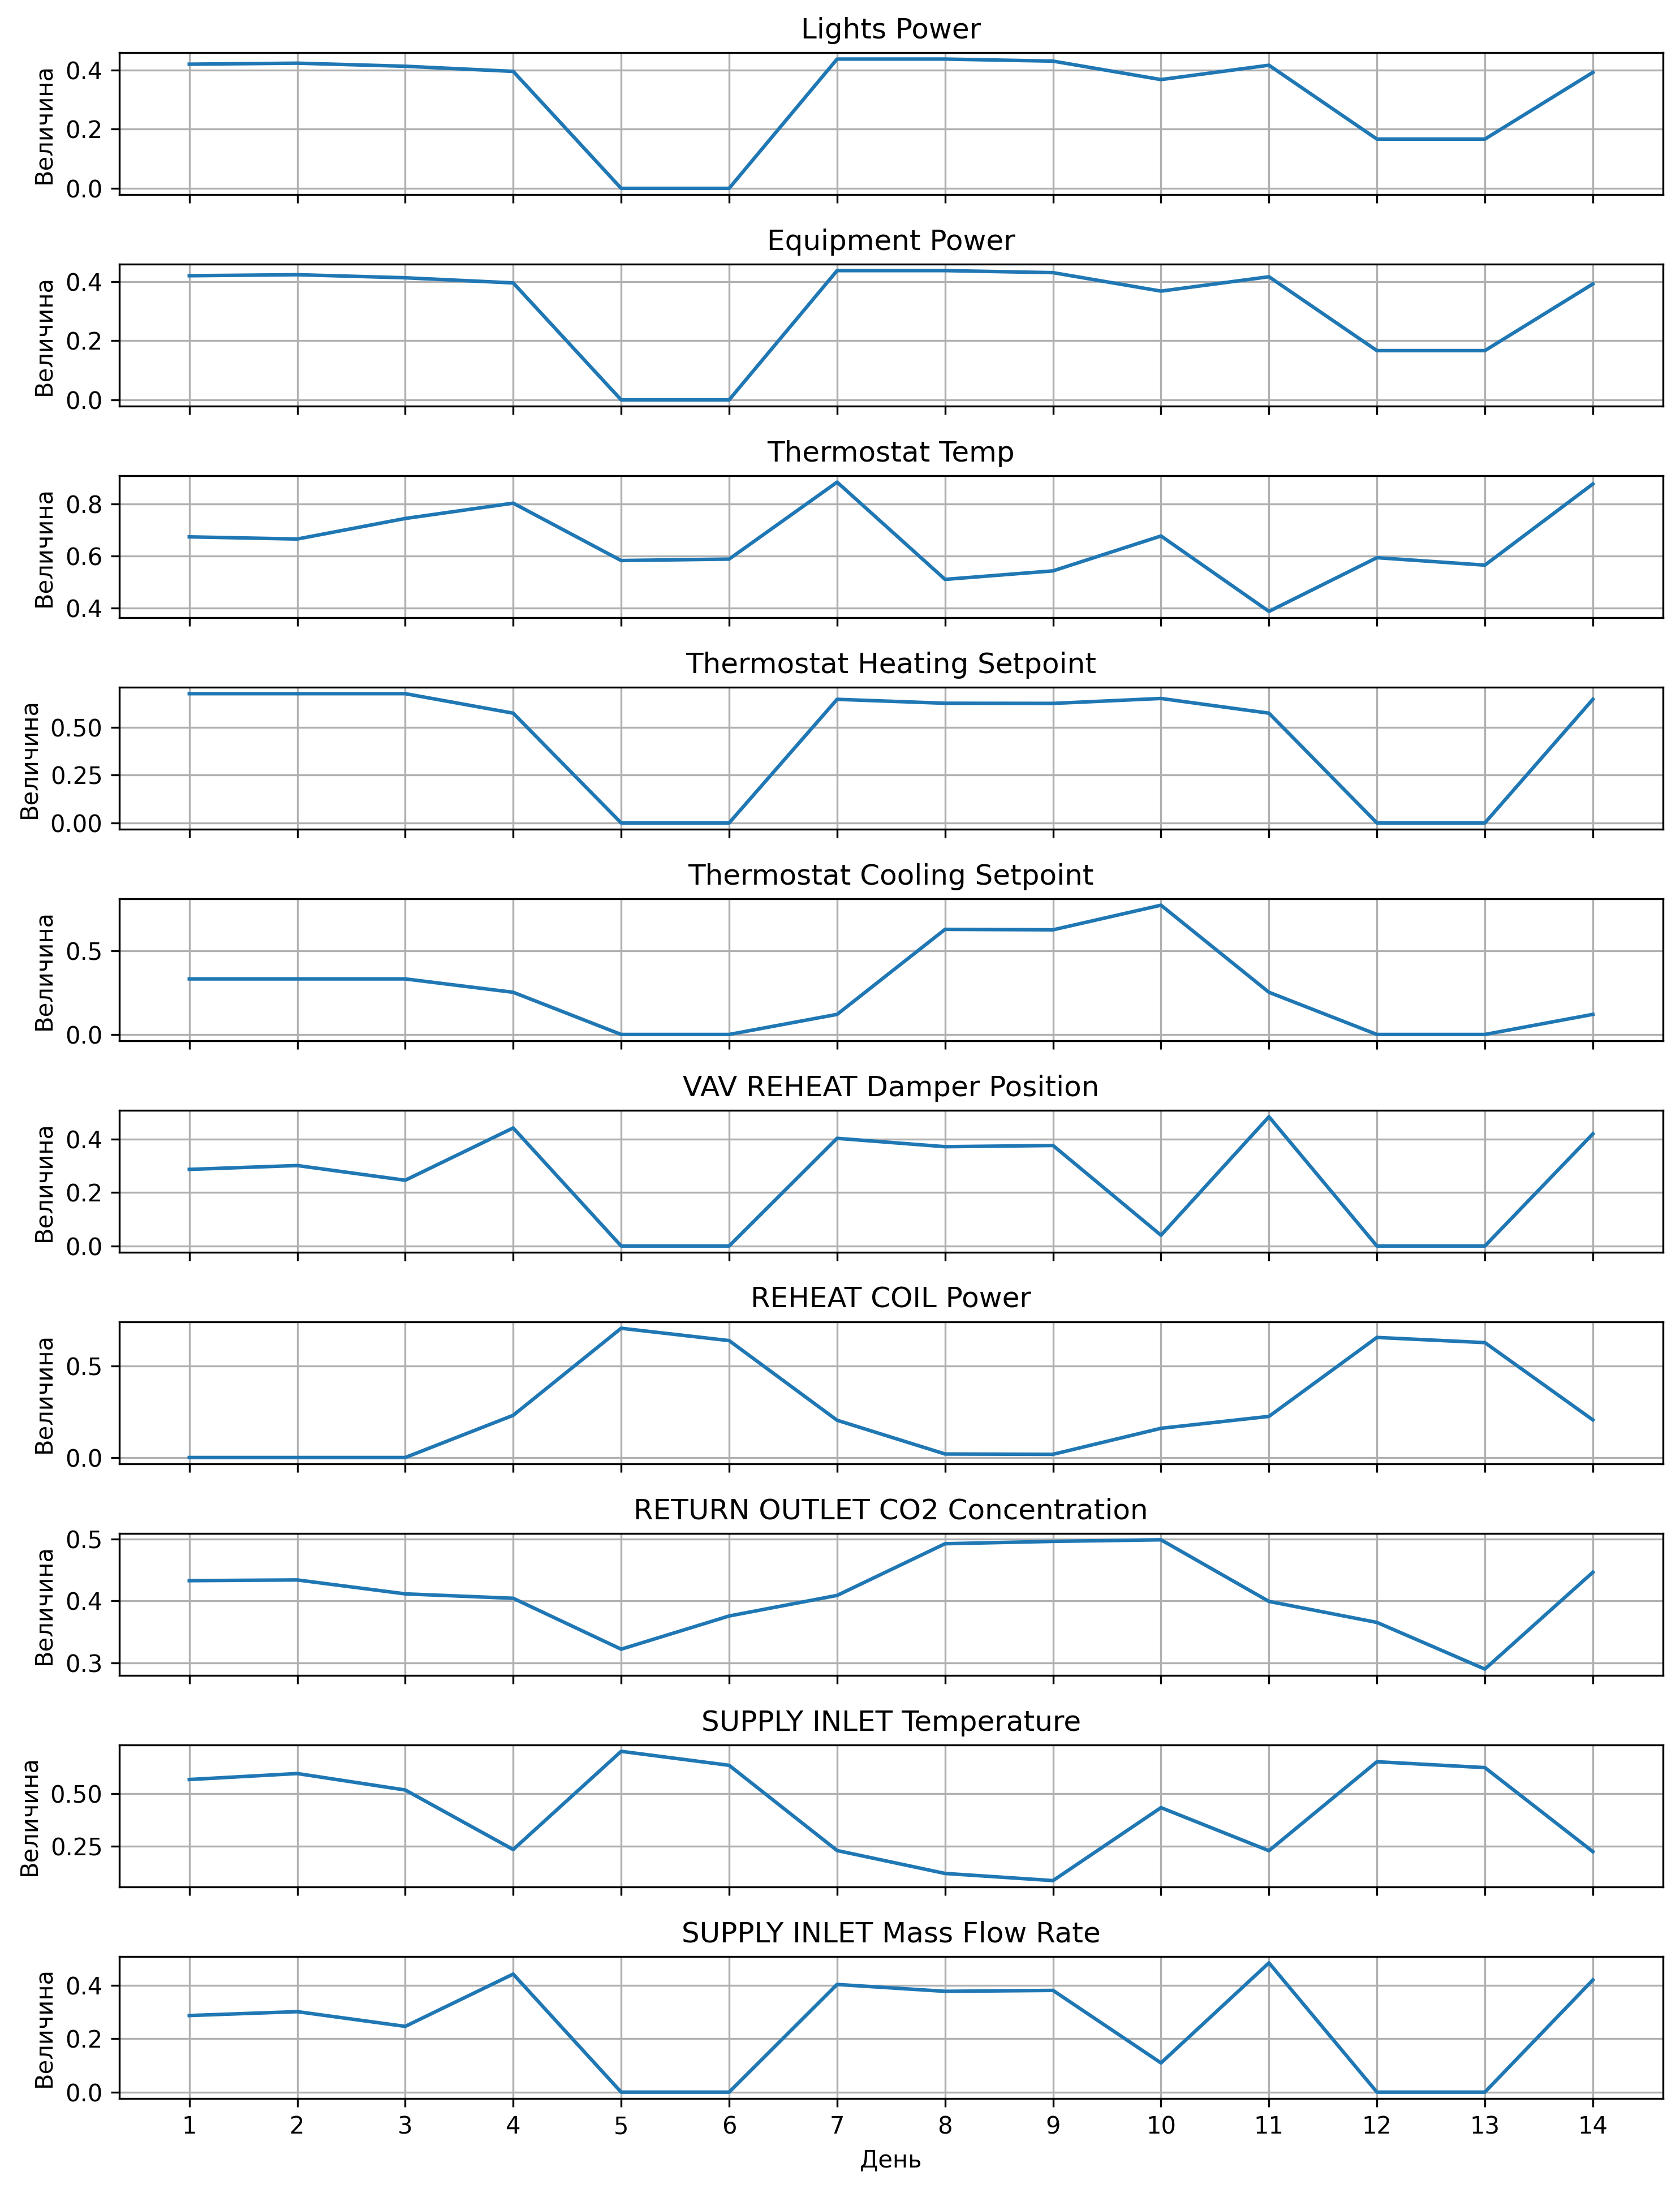

In [235]:
df_means = pd.DataFrame([df.mean() for df in dfs], columns=dfs[0].keys())

display(df_means)

fig, ax = plt.subplots(df_means.shape[1], sharex=True)

for i, key in enumerate(df_means):
    ax[i].plot(df_means[key])
    ax[i].set_title(key)
    ax[i].set_ylabel("Величина")
    ax[i].grid()

_ = ax[-1].set_xticks(range(Ndays))
_ = ax[-1].set_xticklabels(map(str, range(1, 15)))
_ = ax[-1].set_xlabel("День")


fig.set_size_inches(10, 13)
fig.tight_layout()

display(fig)

Из графиков видно, что Lights Power и Equipment Power, а так же VAV REHEAT Damper Position и SUPPLY INLET Mass Flow Rate представляют примерно одни и те же зависимости с точностью до масштабного коэффициента, поэтому можно отбросить их при анализе.

- Нормируем данные в каждой колонке

In [230]:
scaled_dfs = dfs
for i, df in enumerate(dfs):
    scaled_tmp = pd.DataFrame(
        preprocessing.MinMaxScaler().fit_transform(df), 
        columns=df.columns
    )
    
    scaled_dfs[i]=scaled_tmp

dfs = scaled_dfs

- Построим матрицы корреляции для каждого дня

День 1

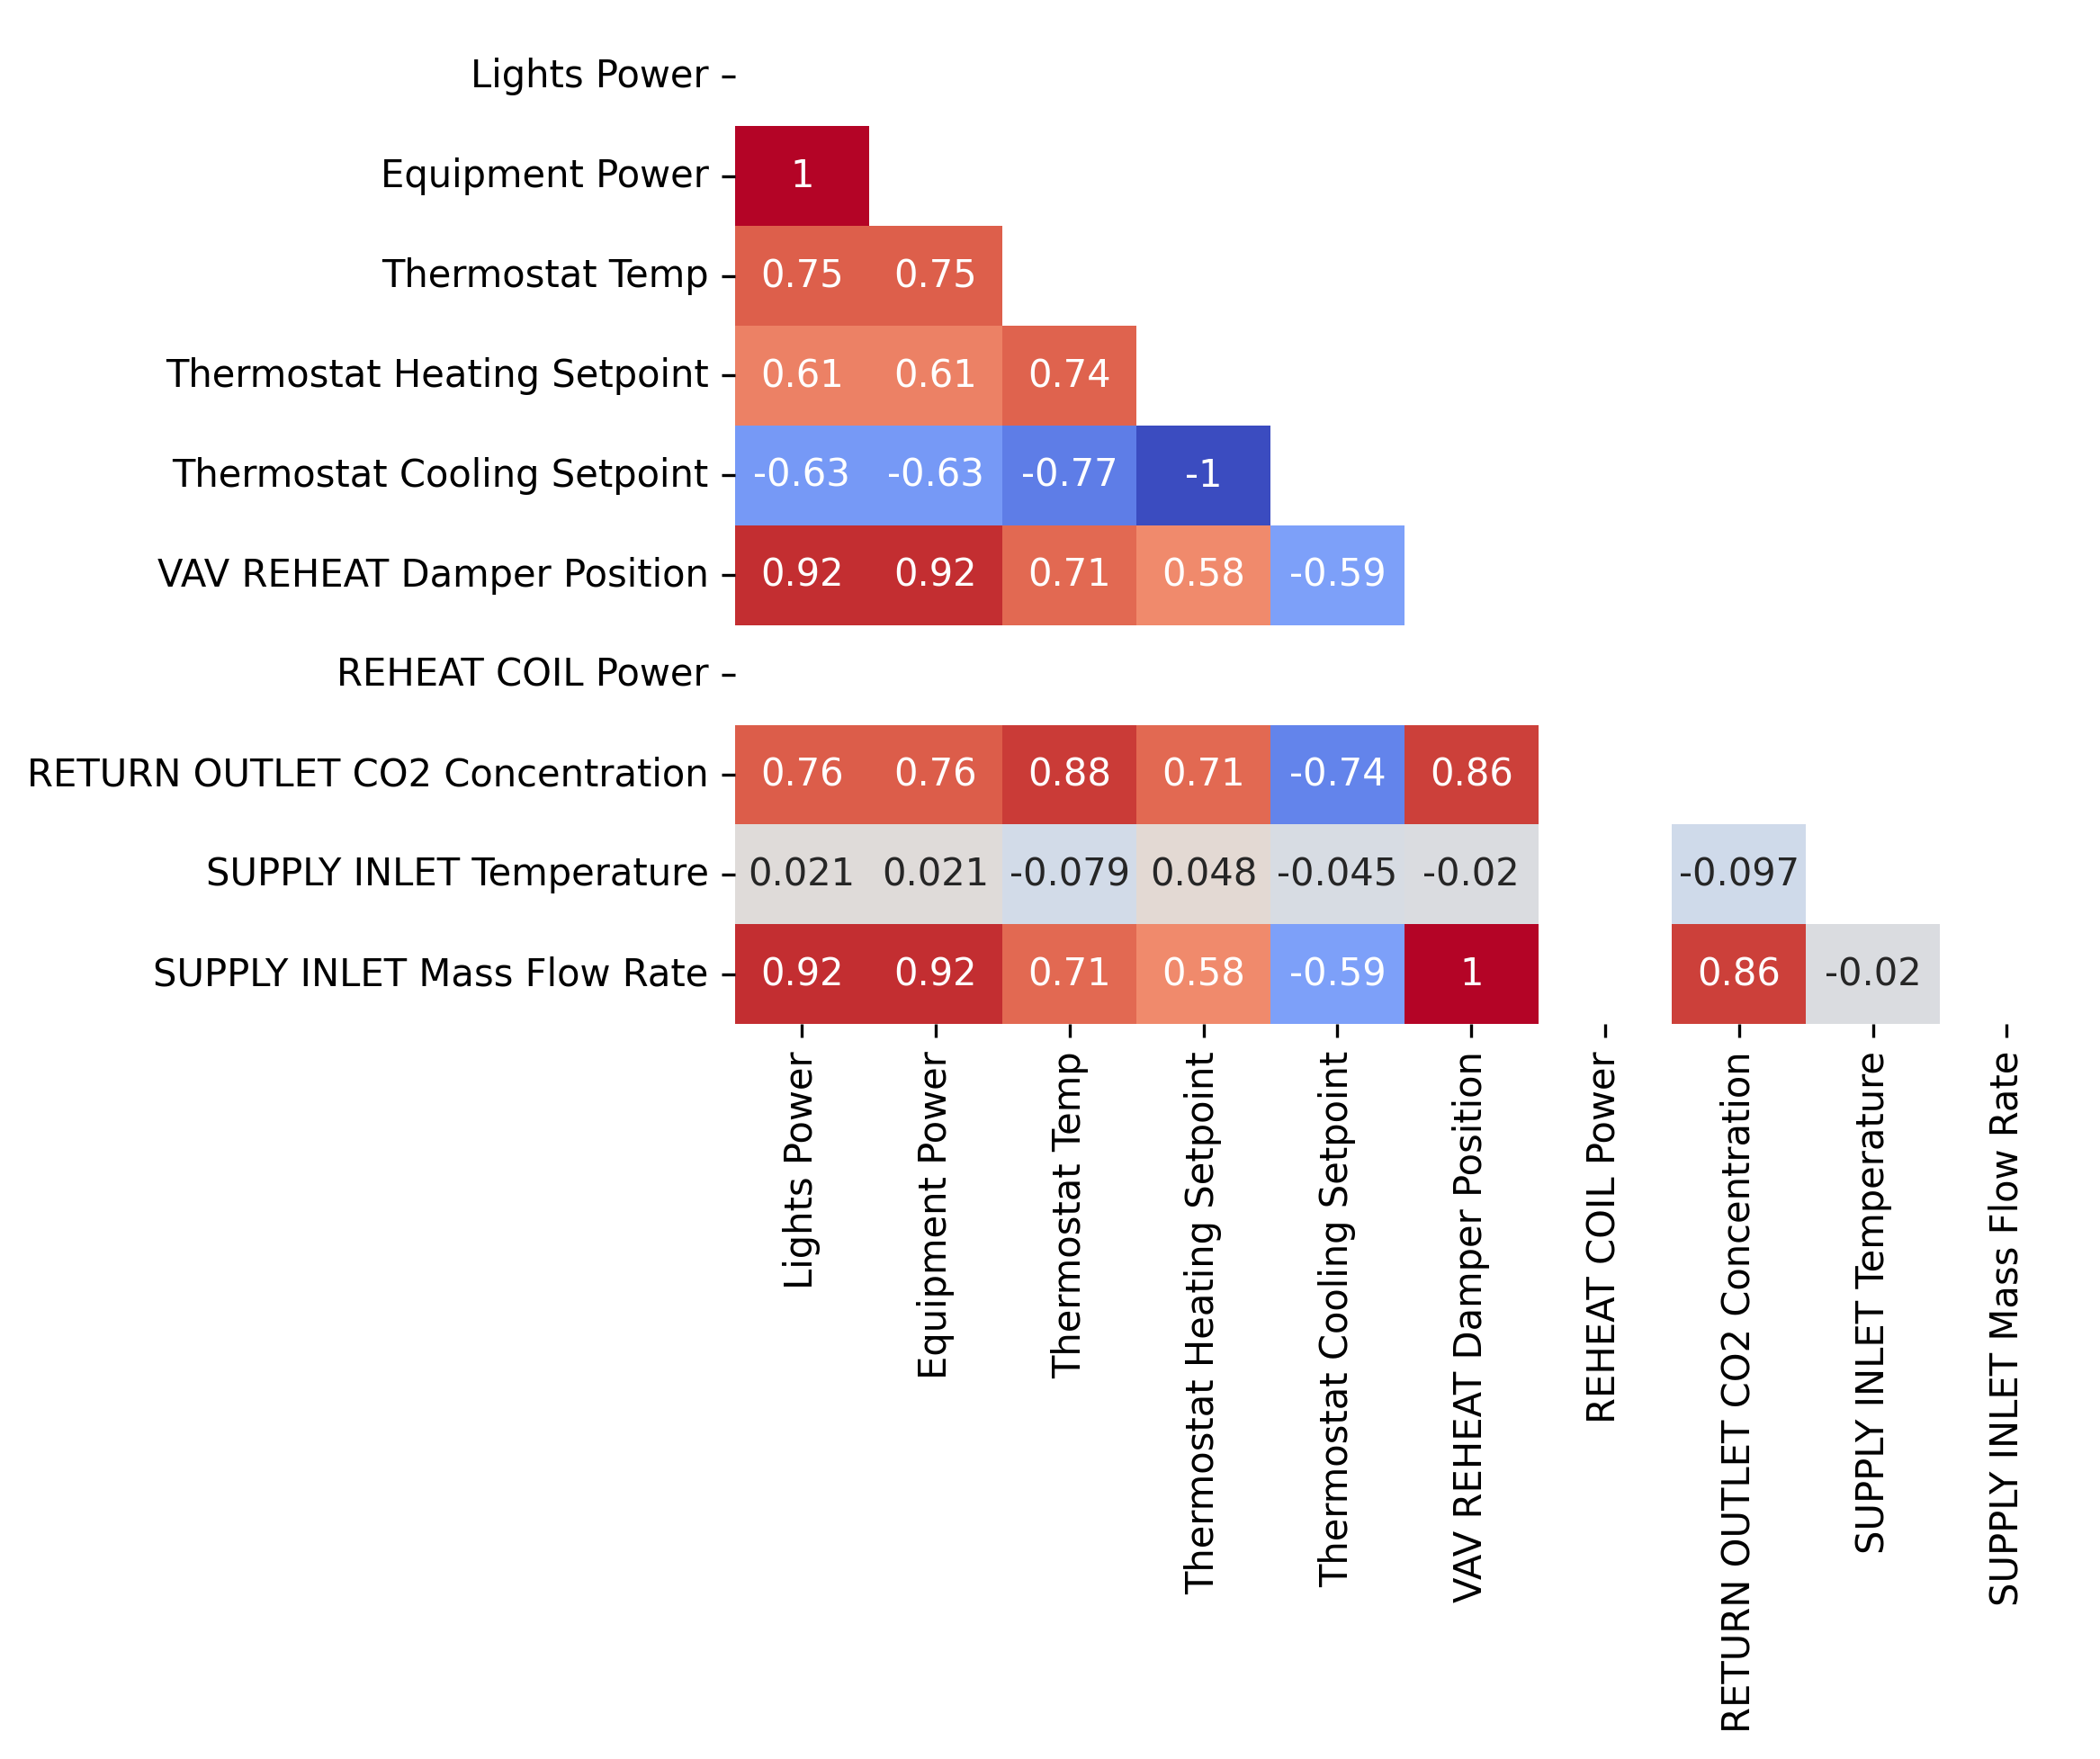

День 2

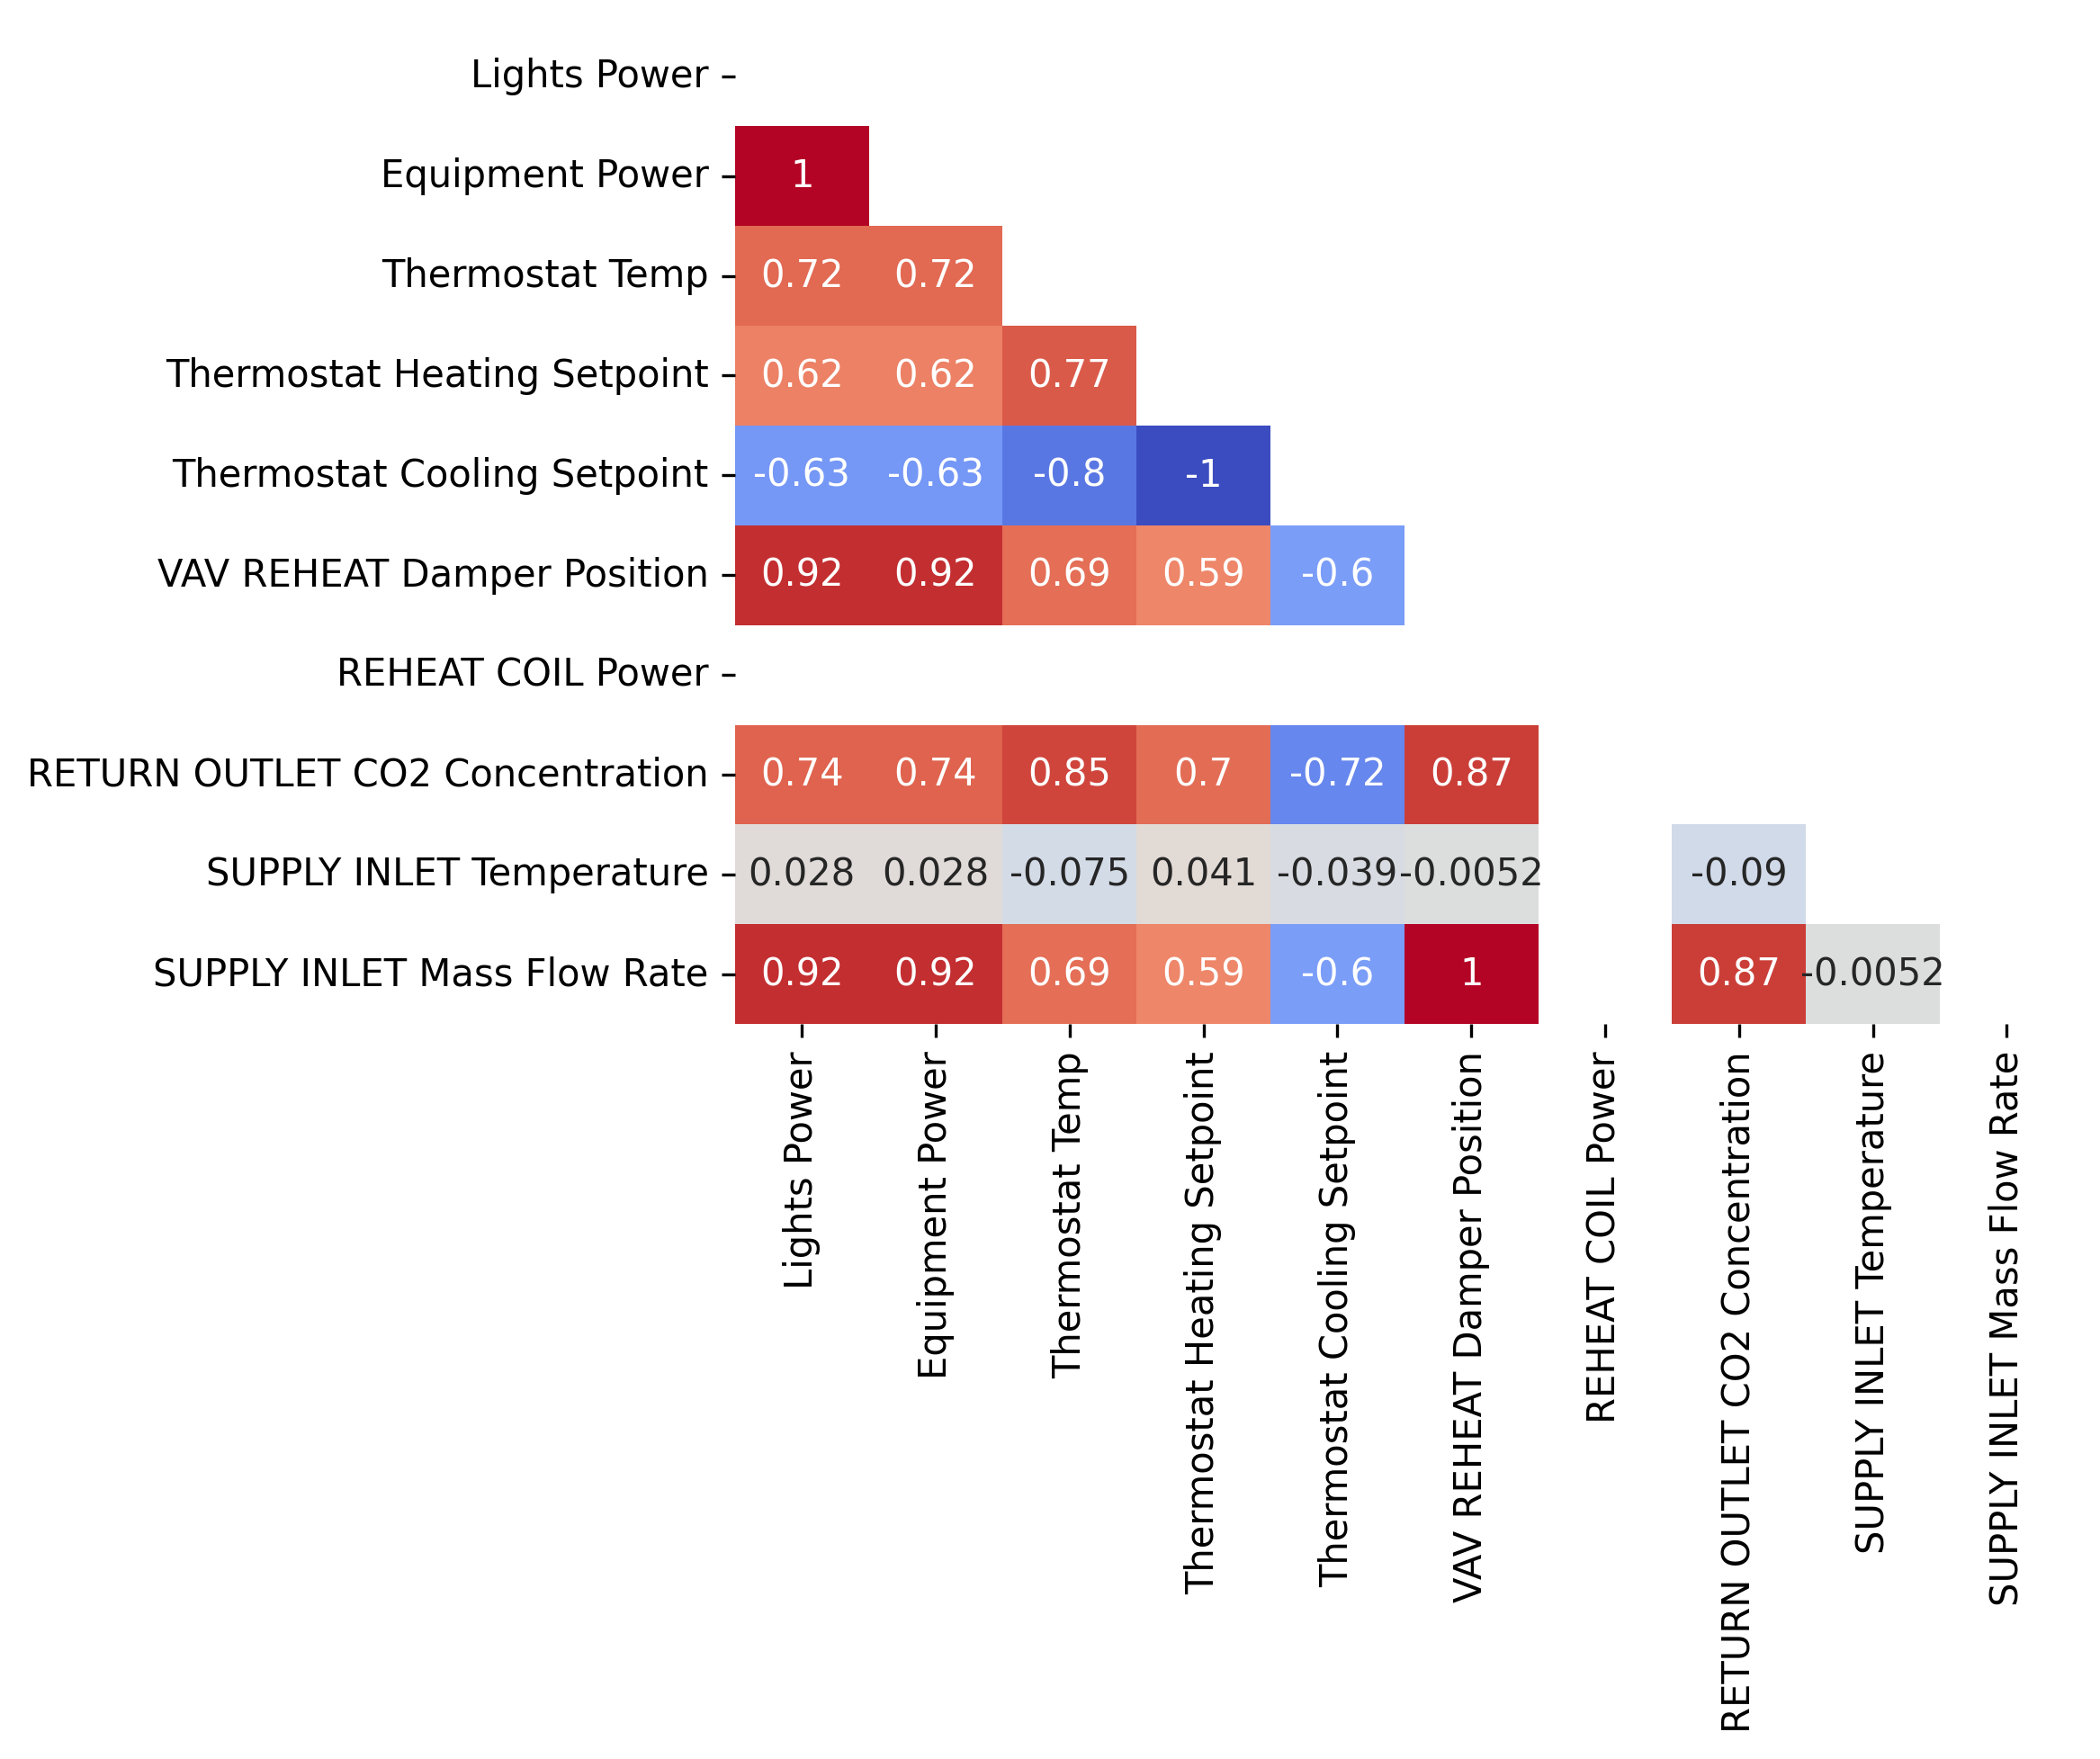

День 3

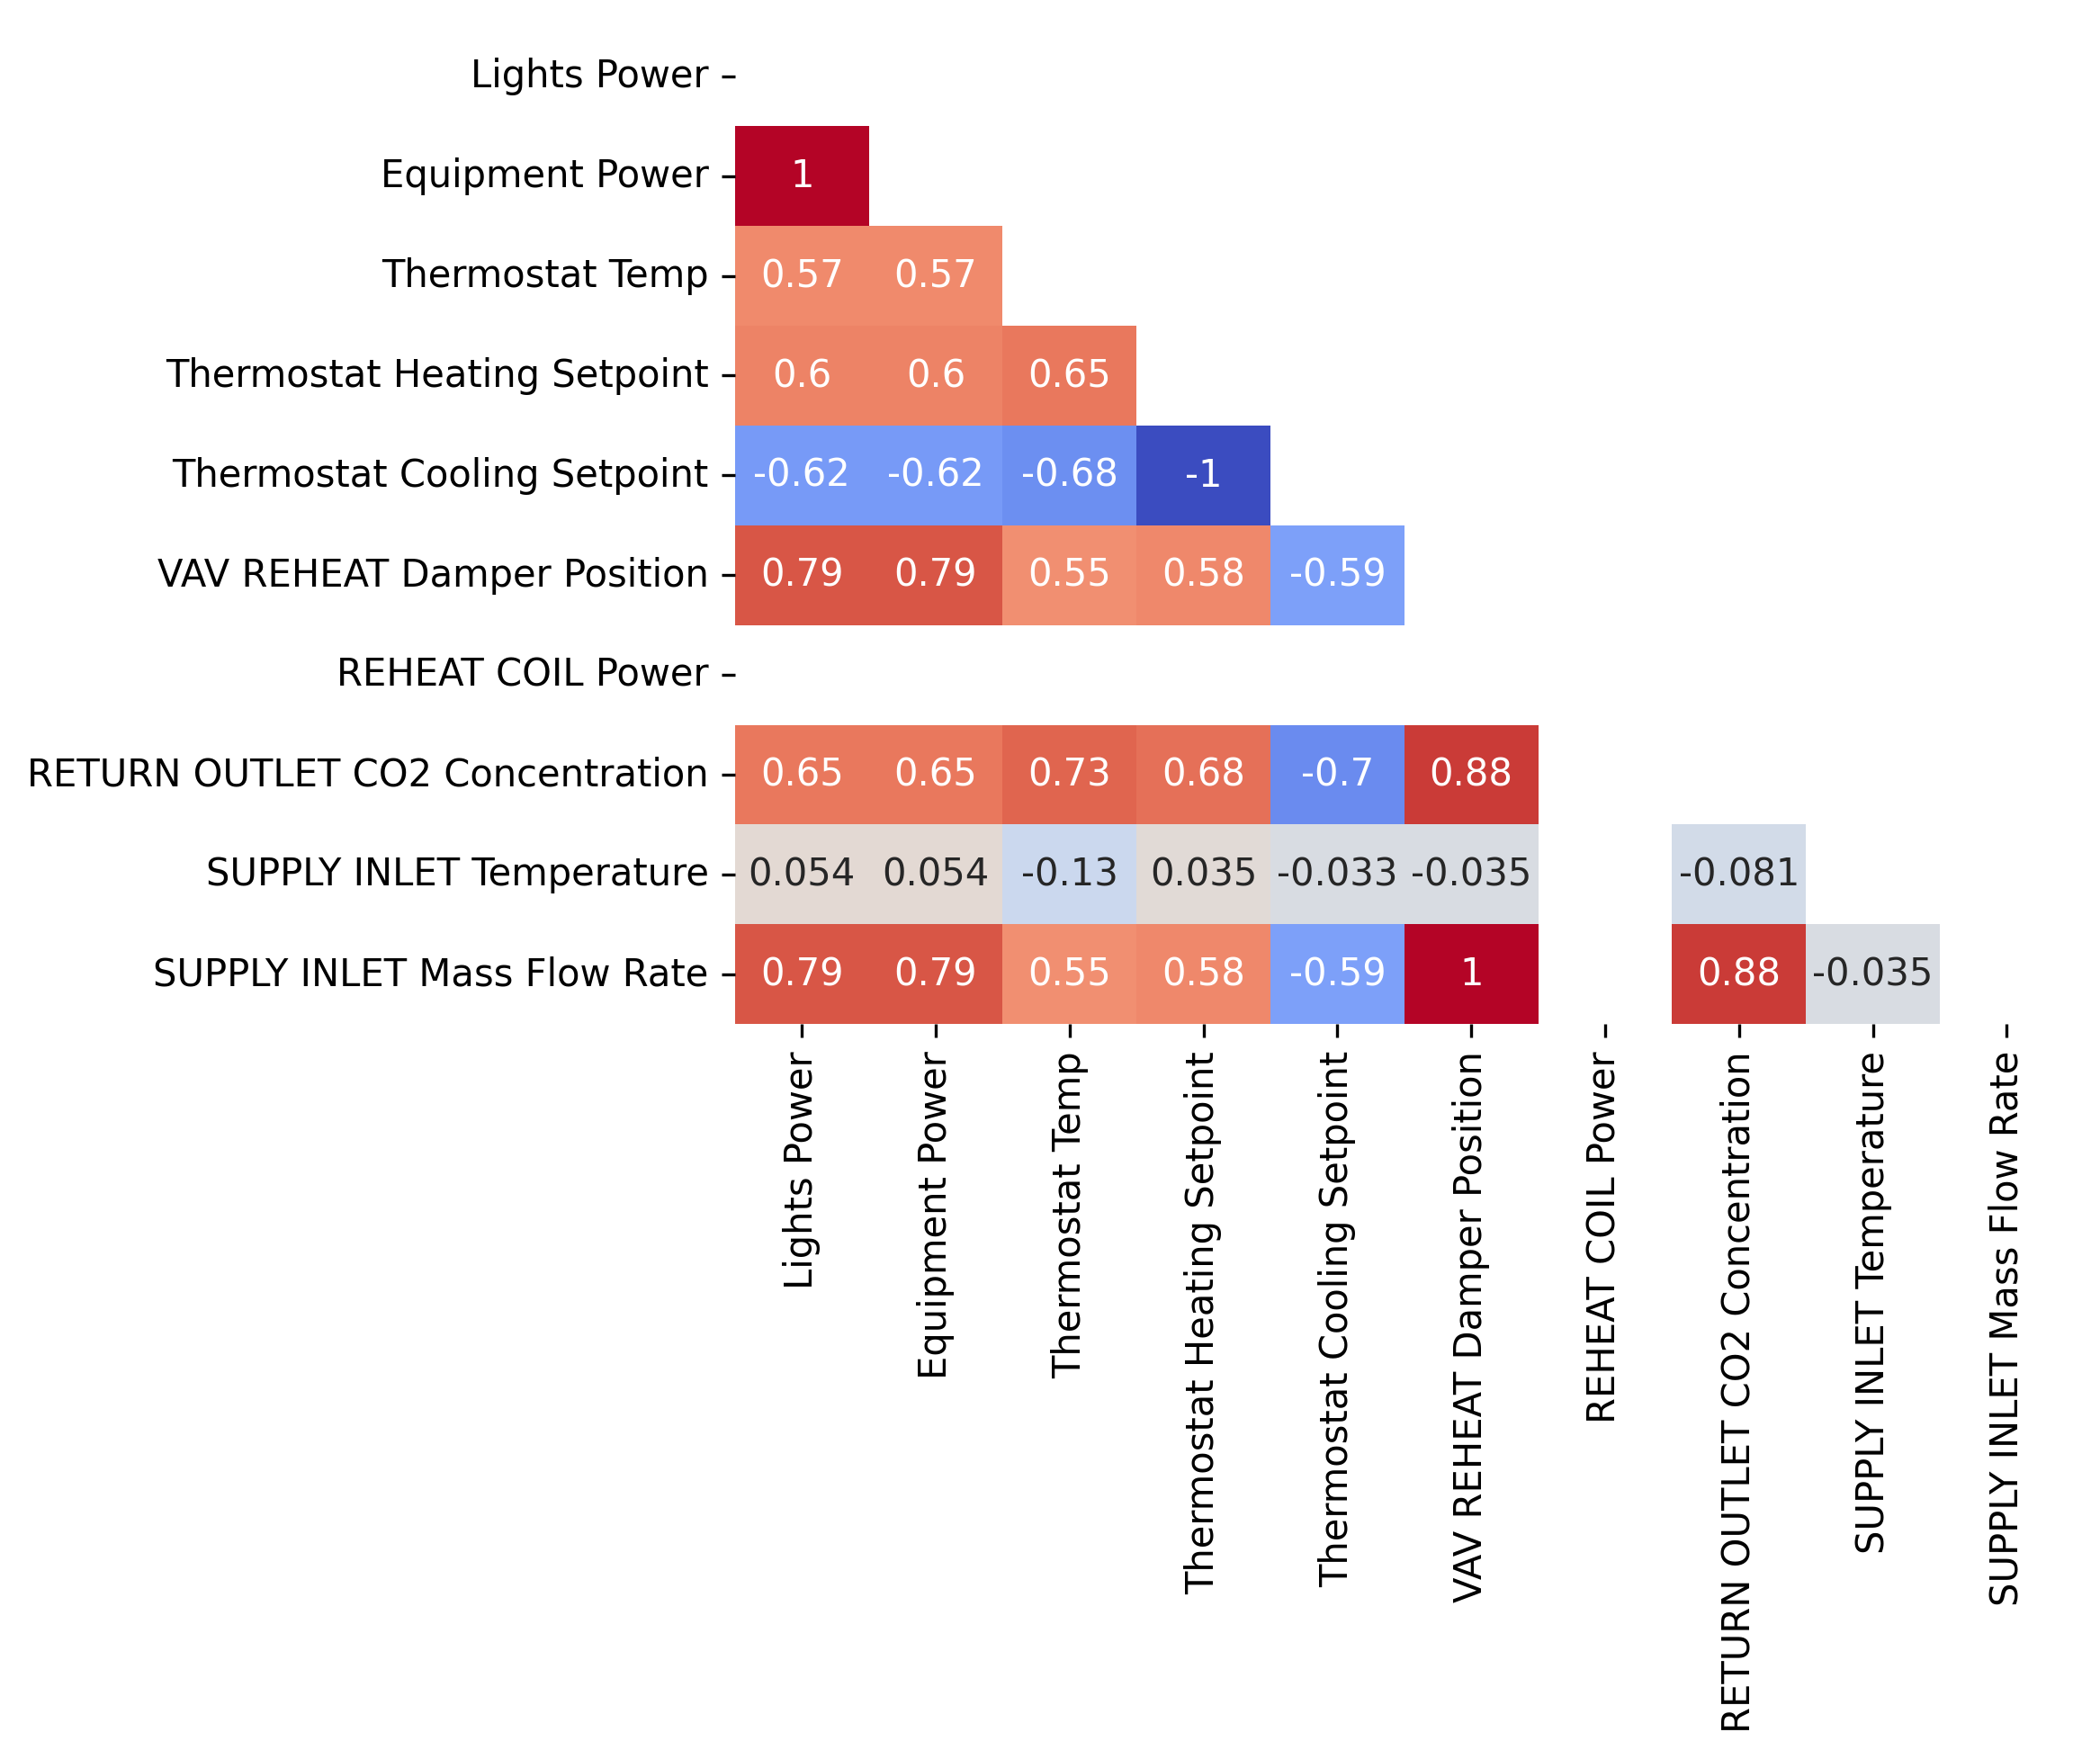

День 4

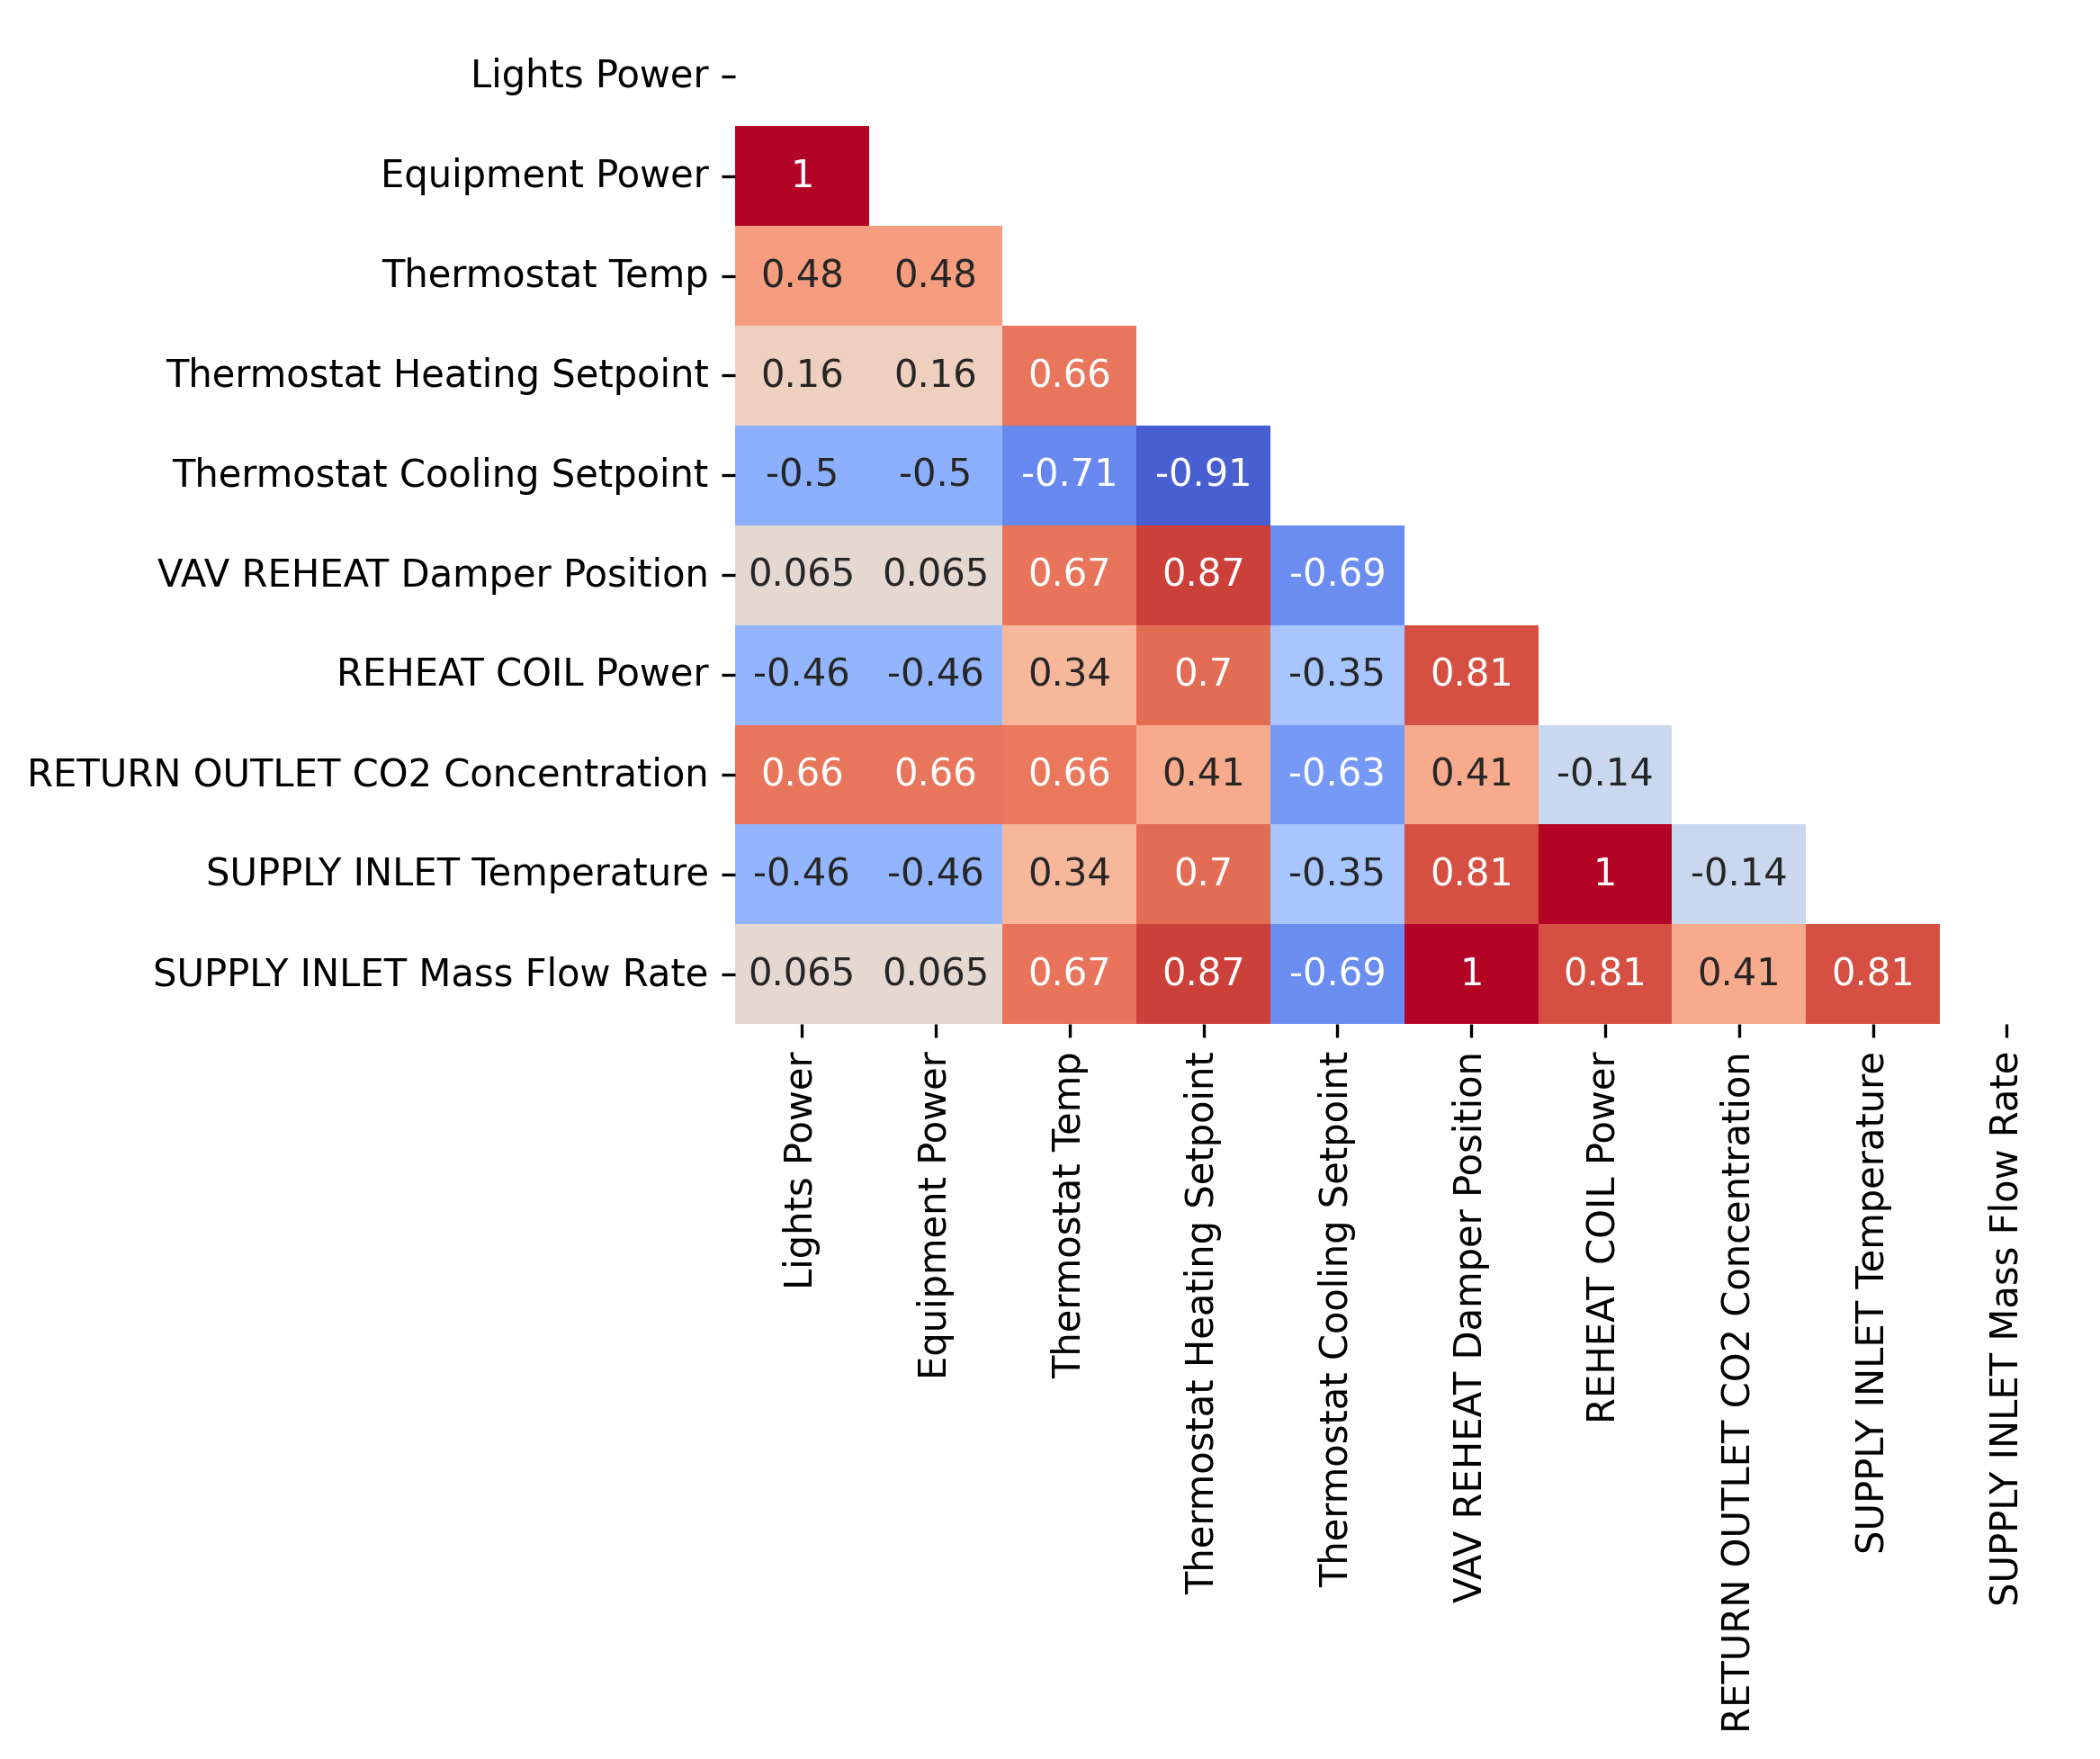

День 5

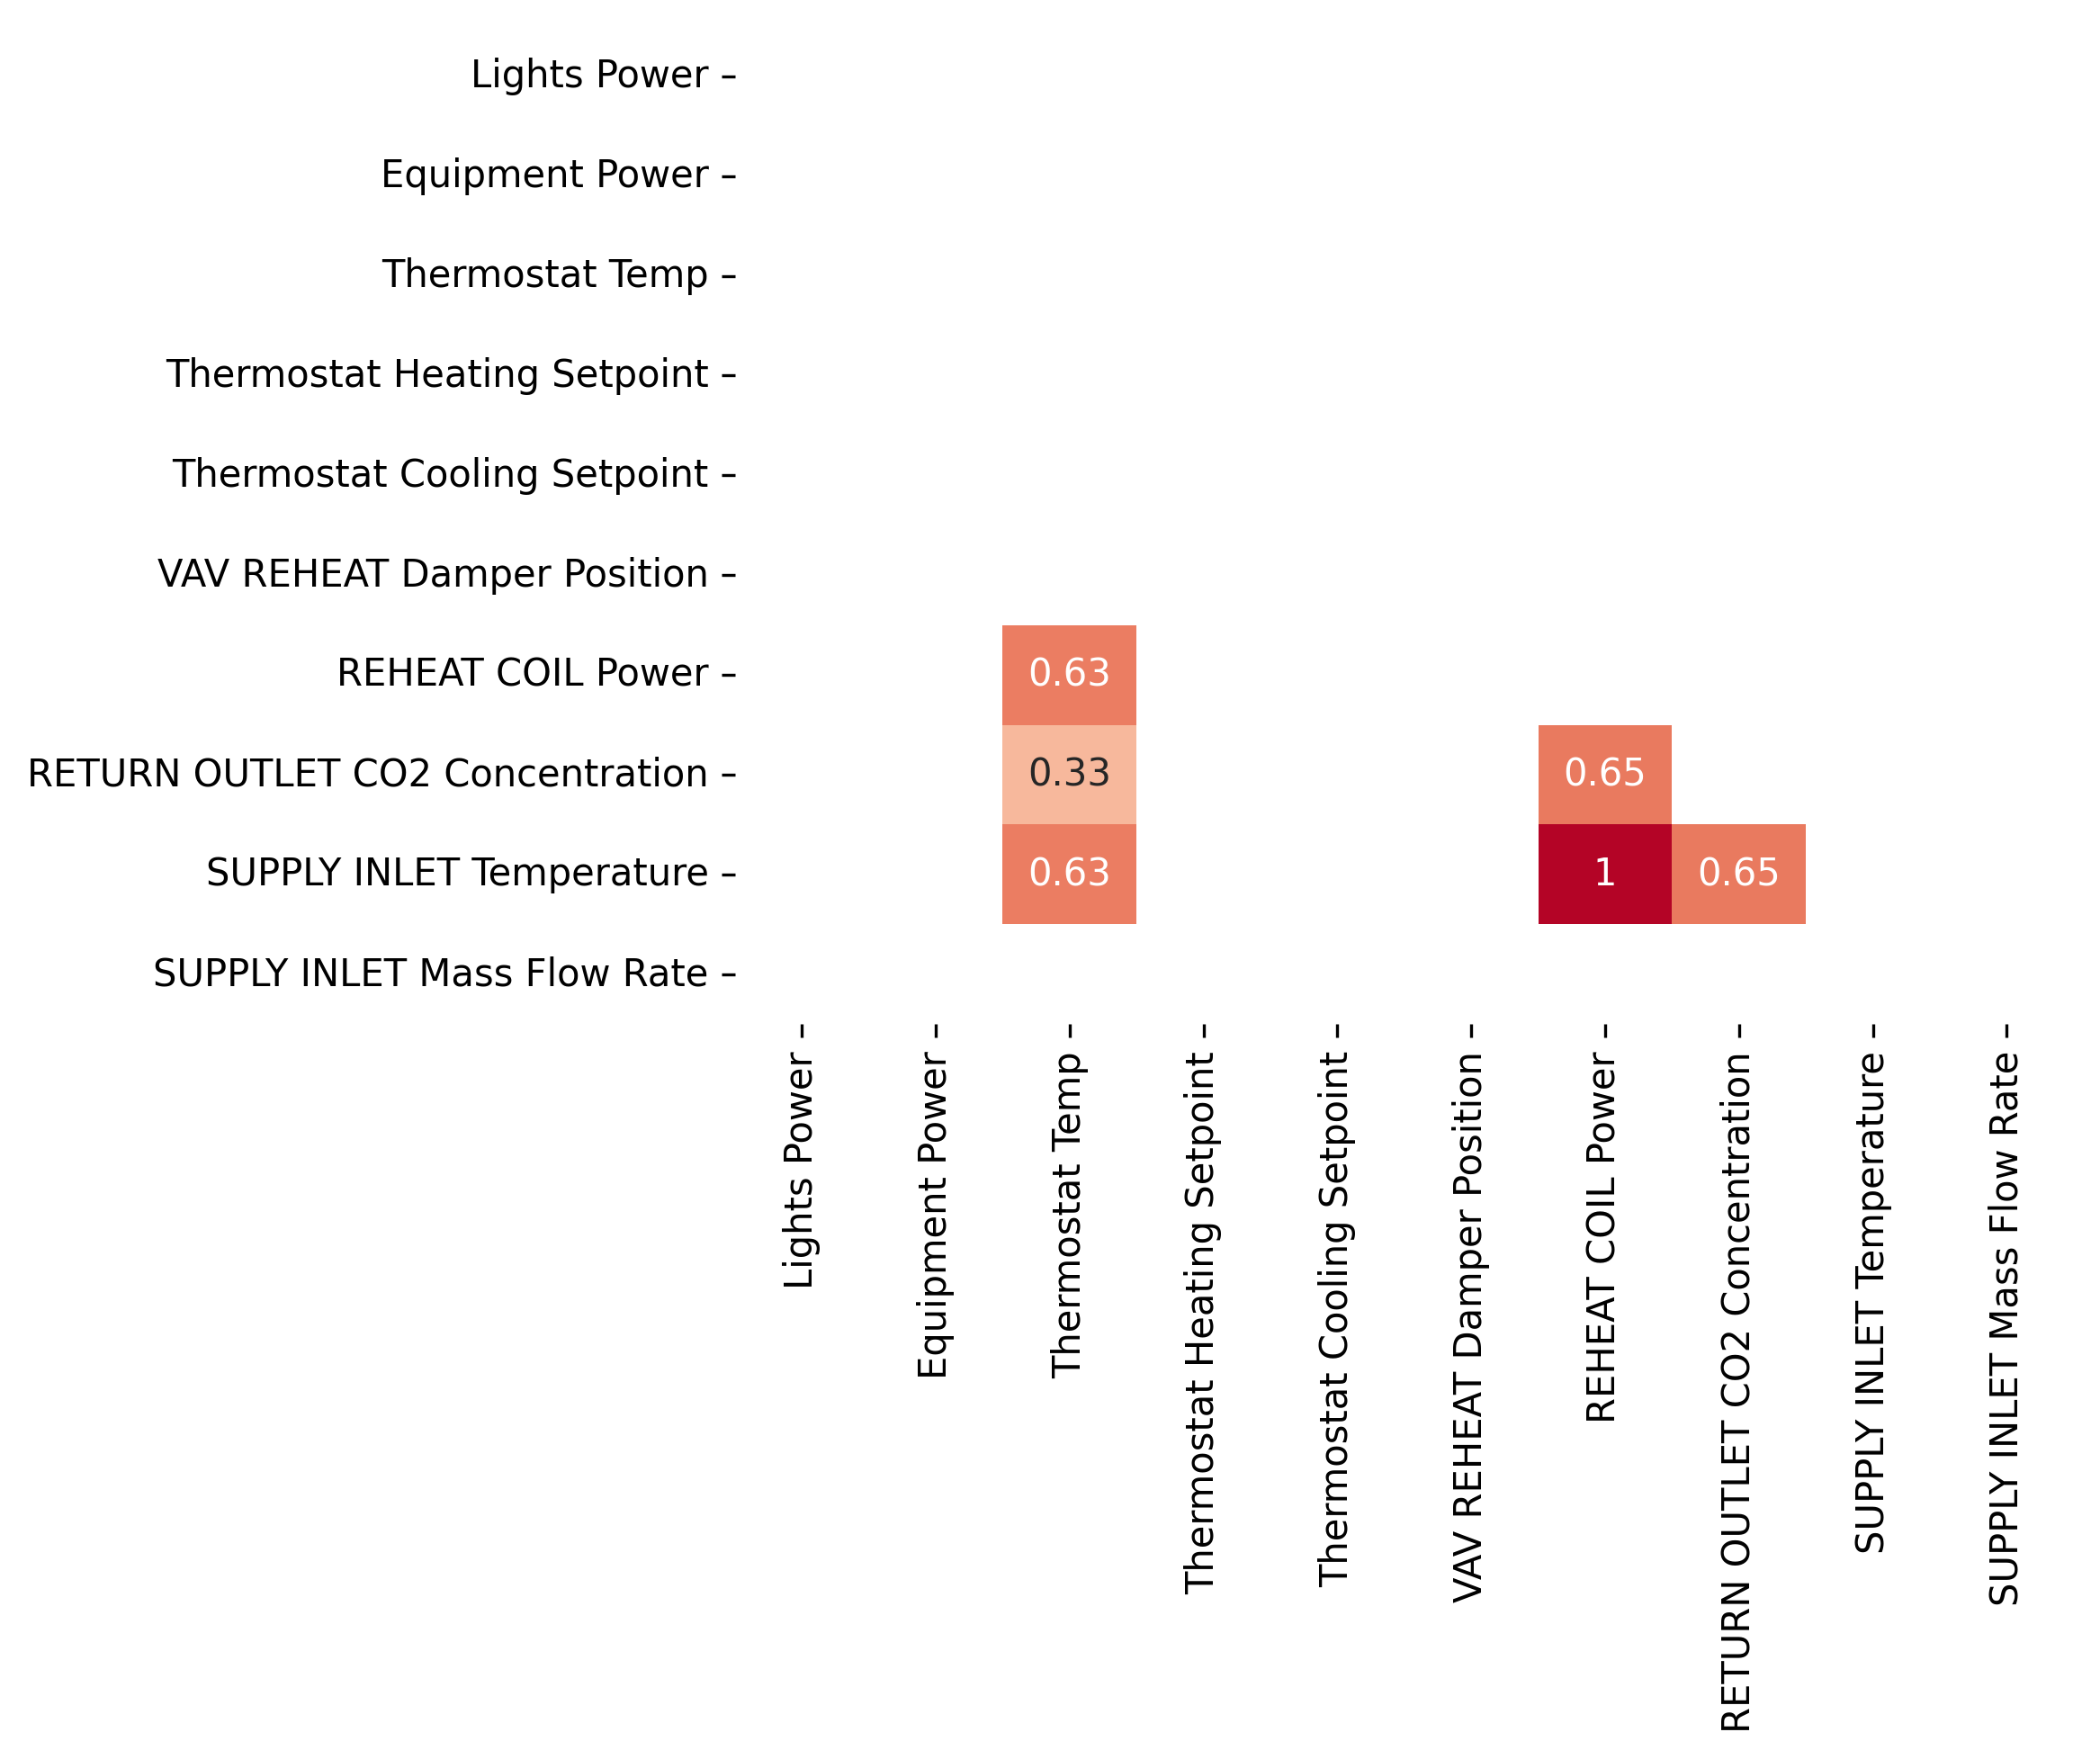

День 6

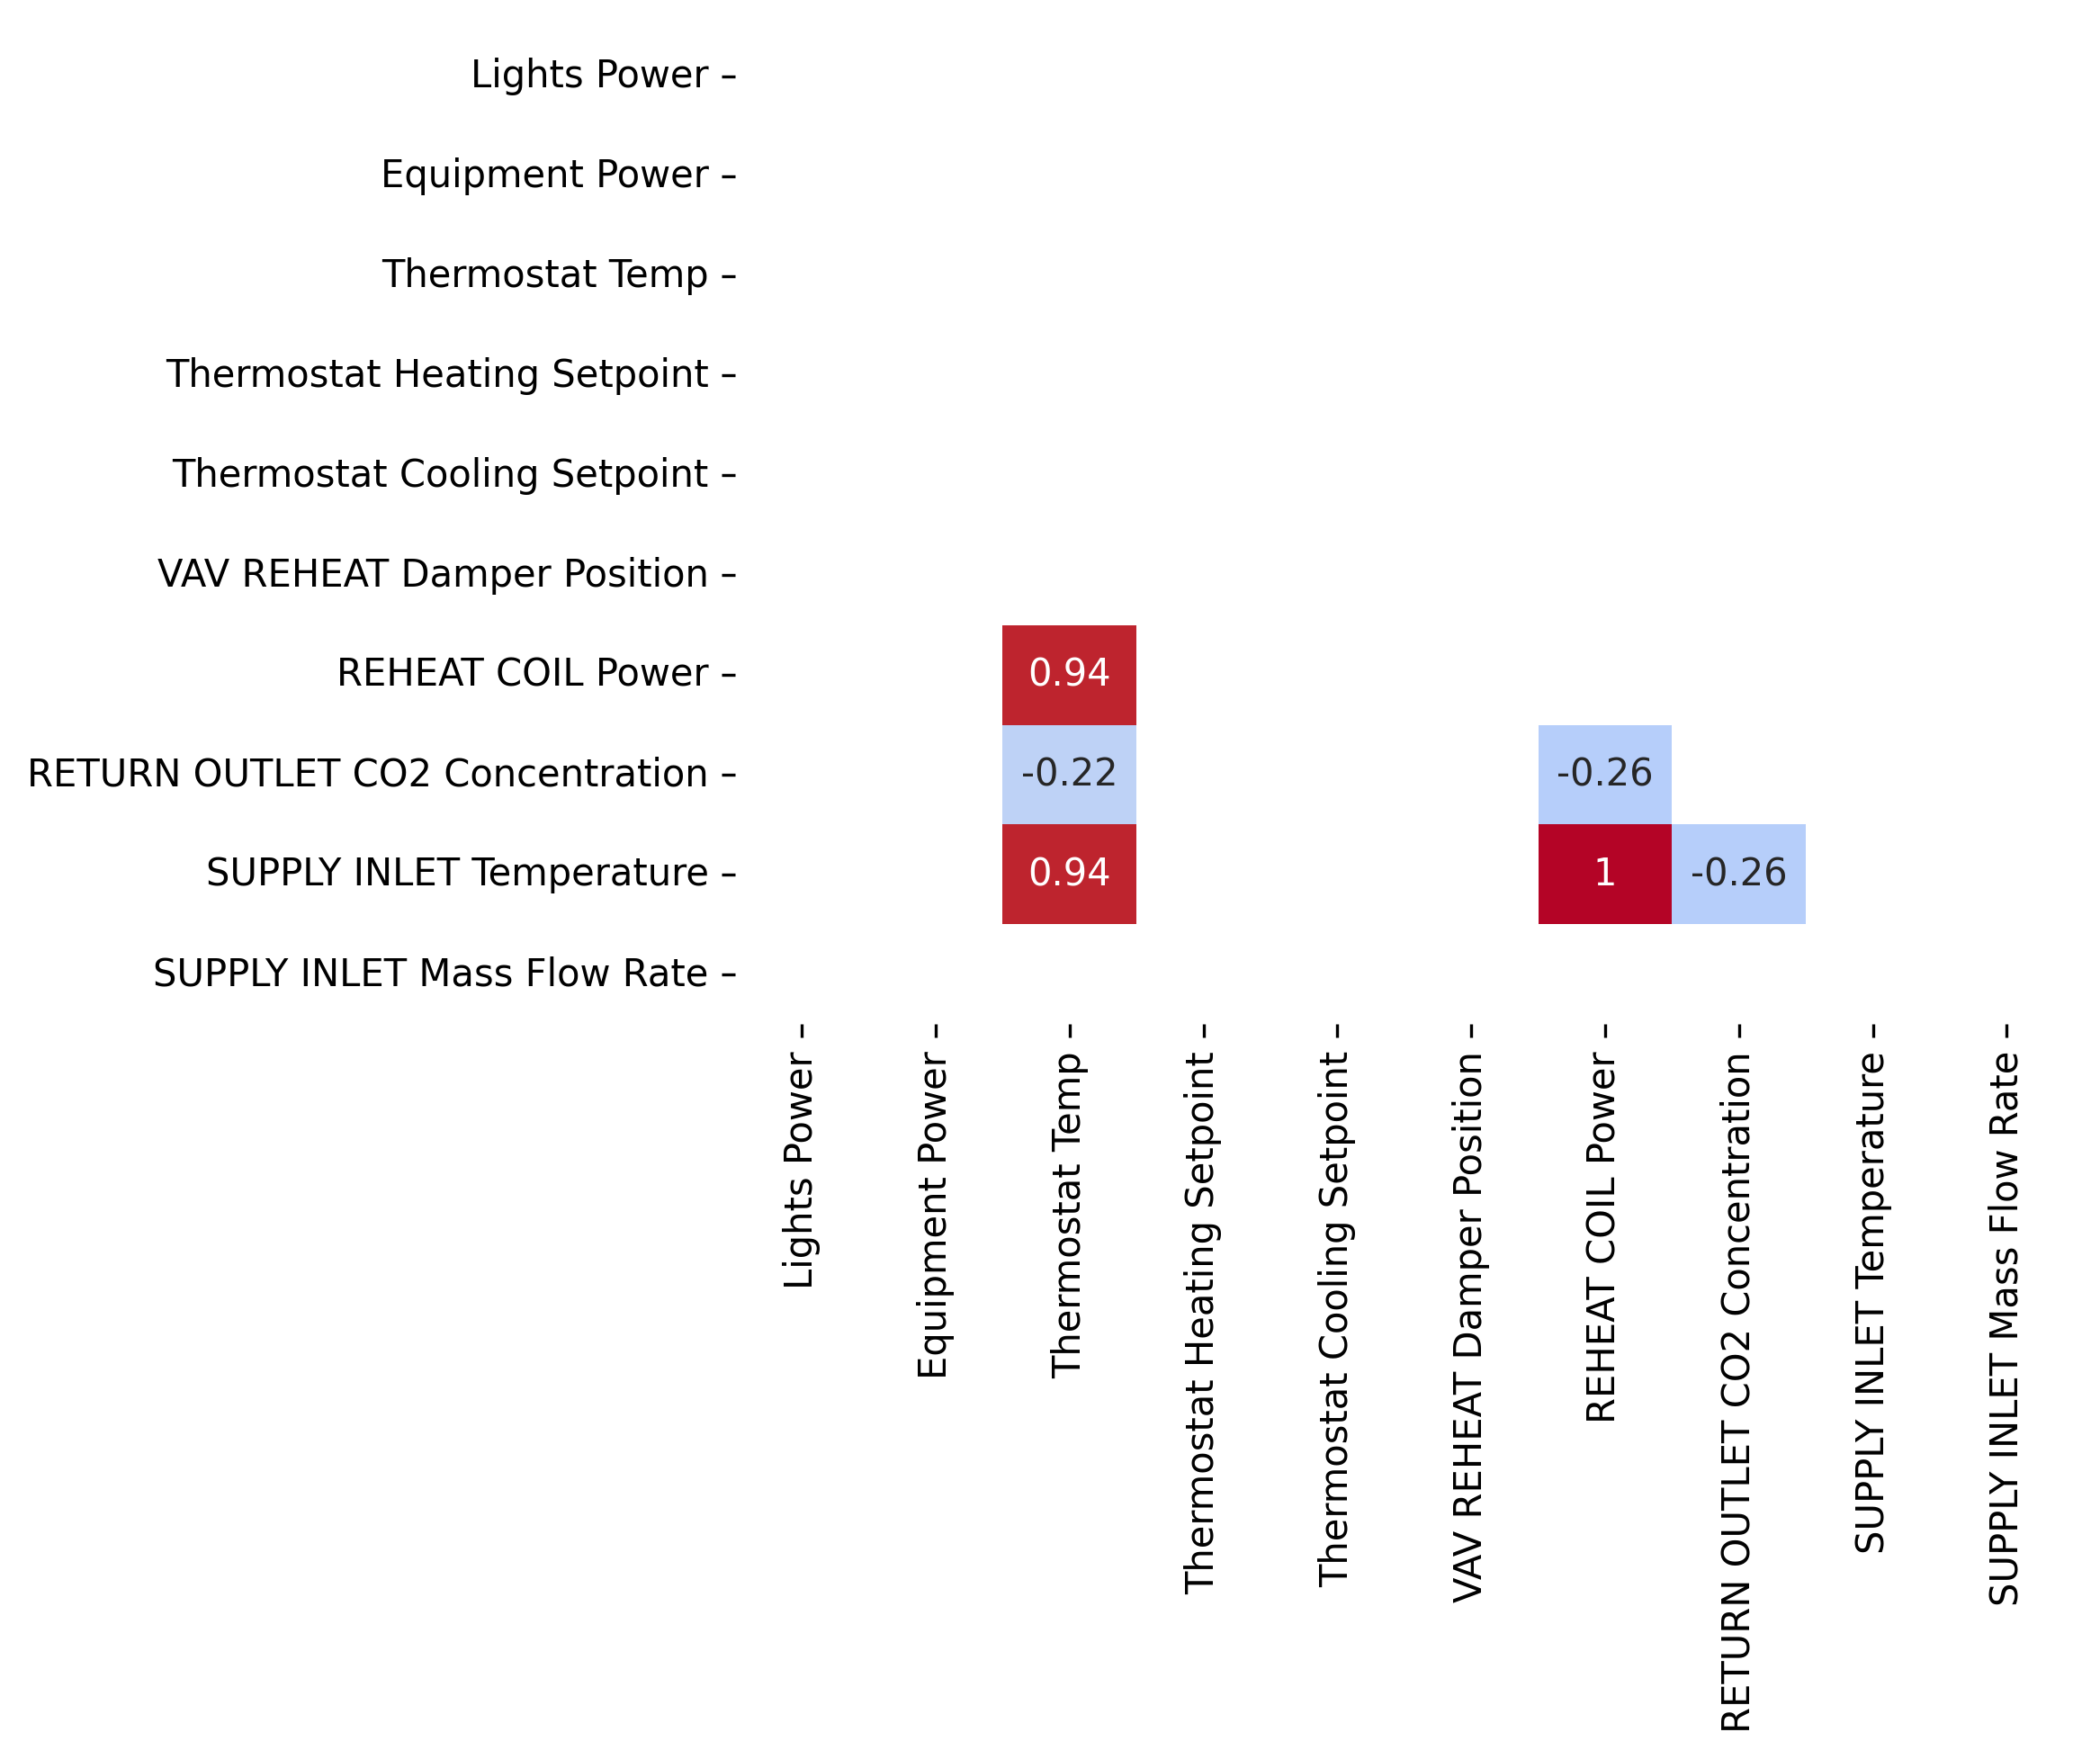

День 7

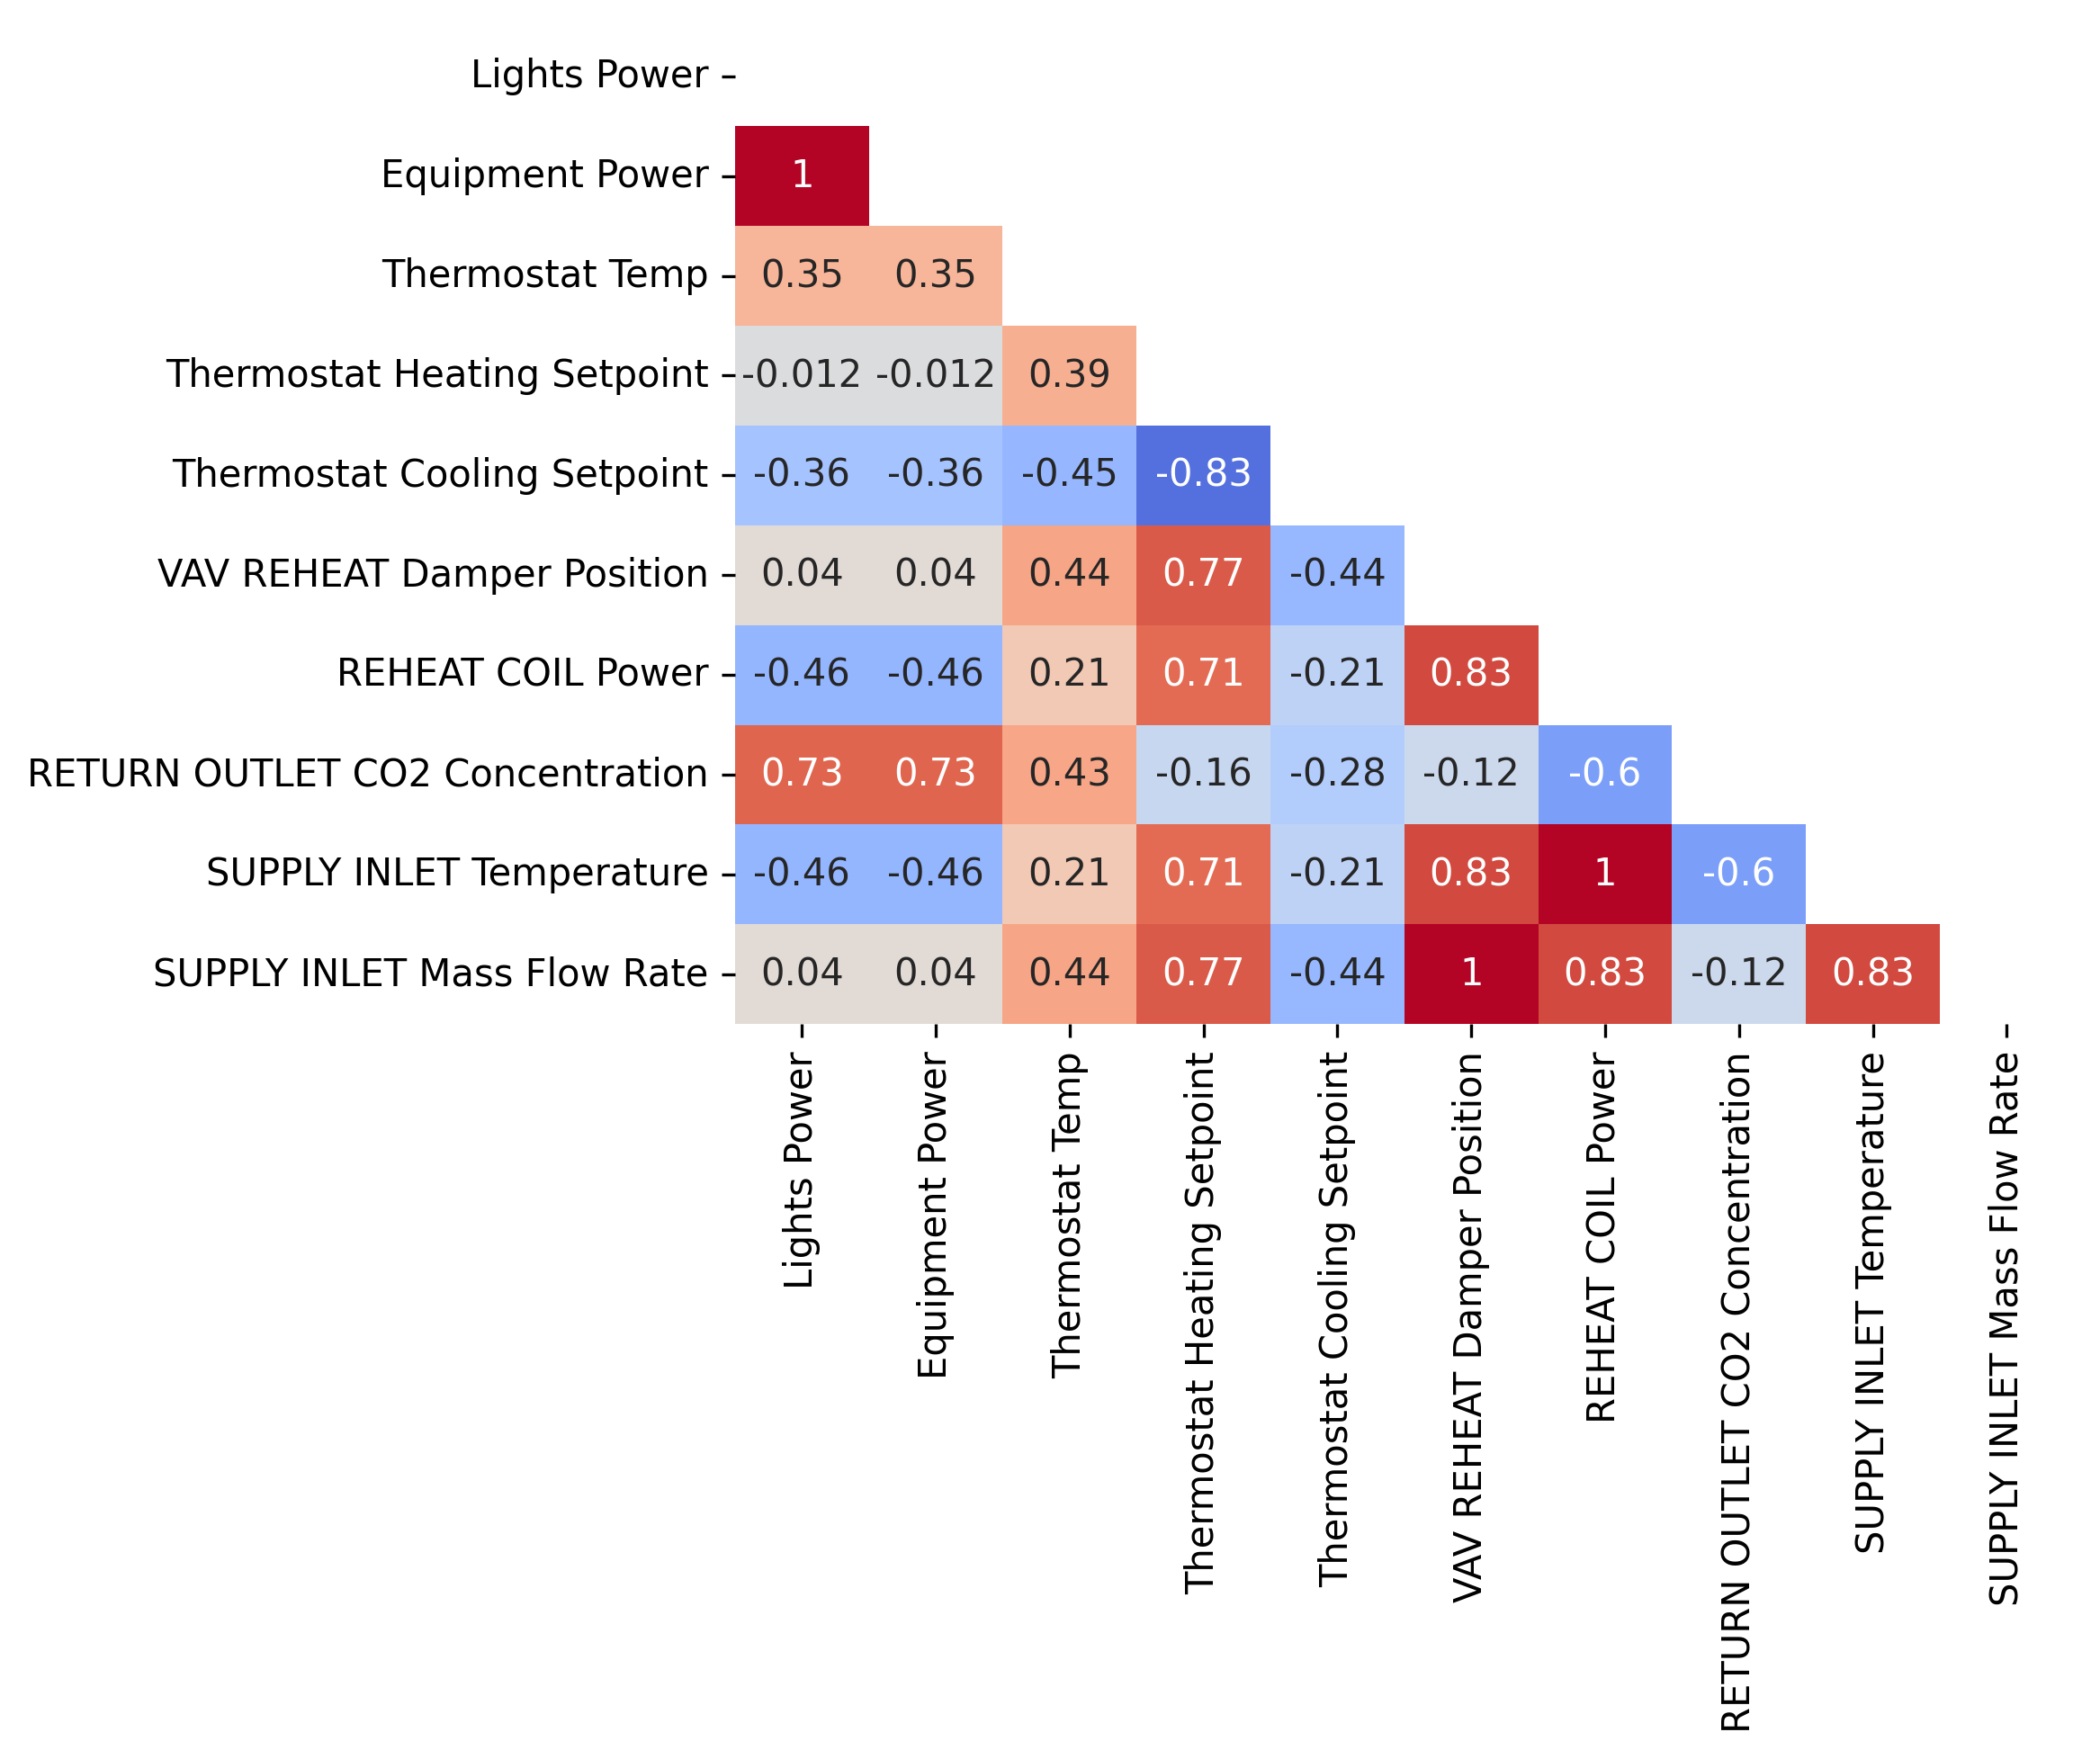

День 8

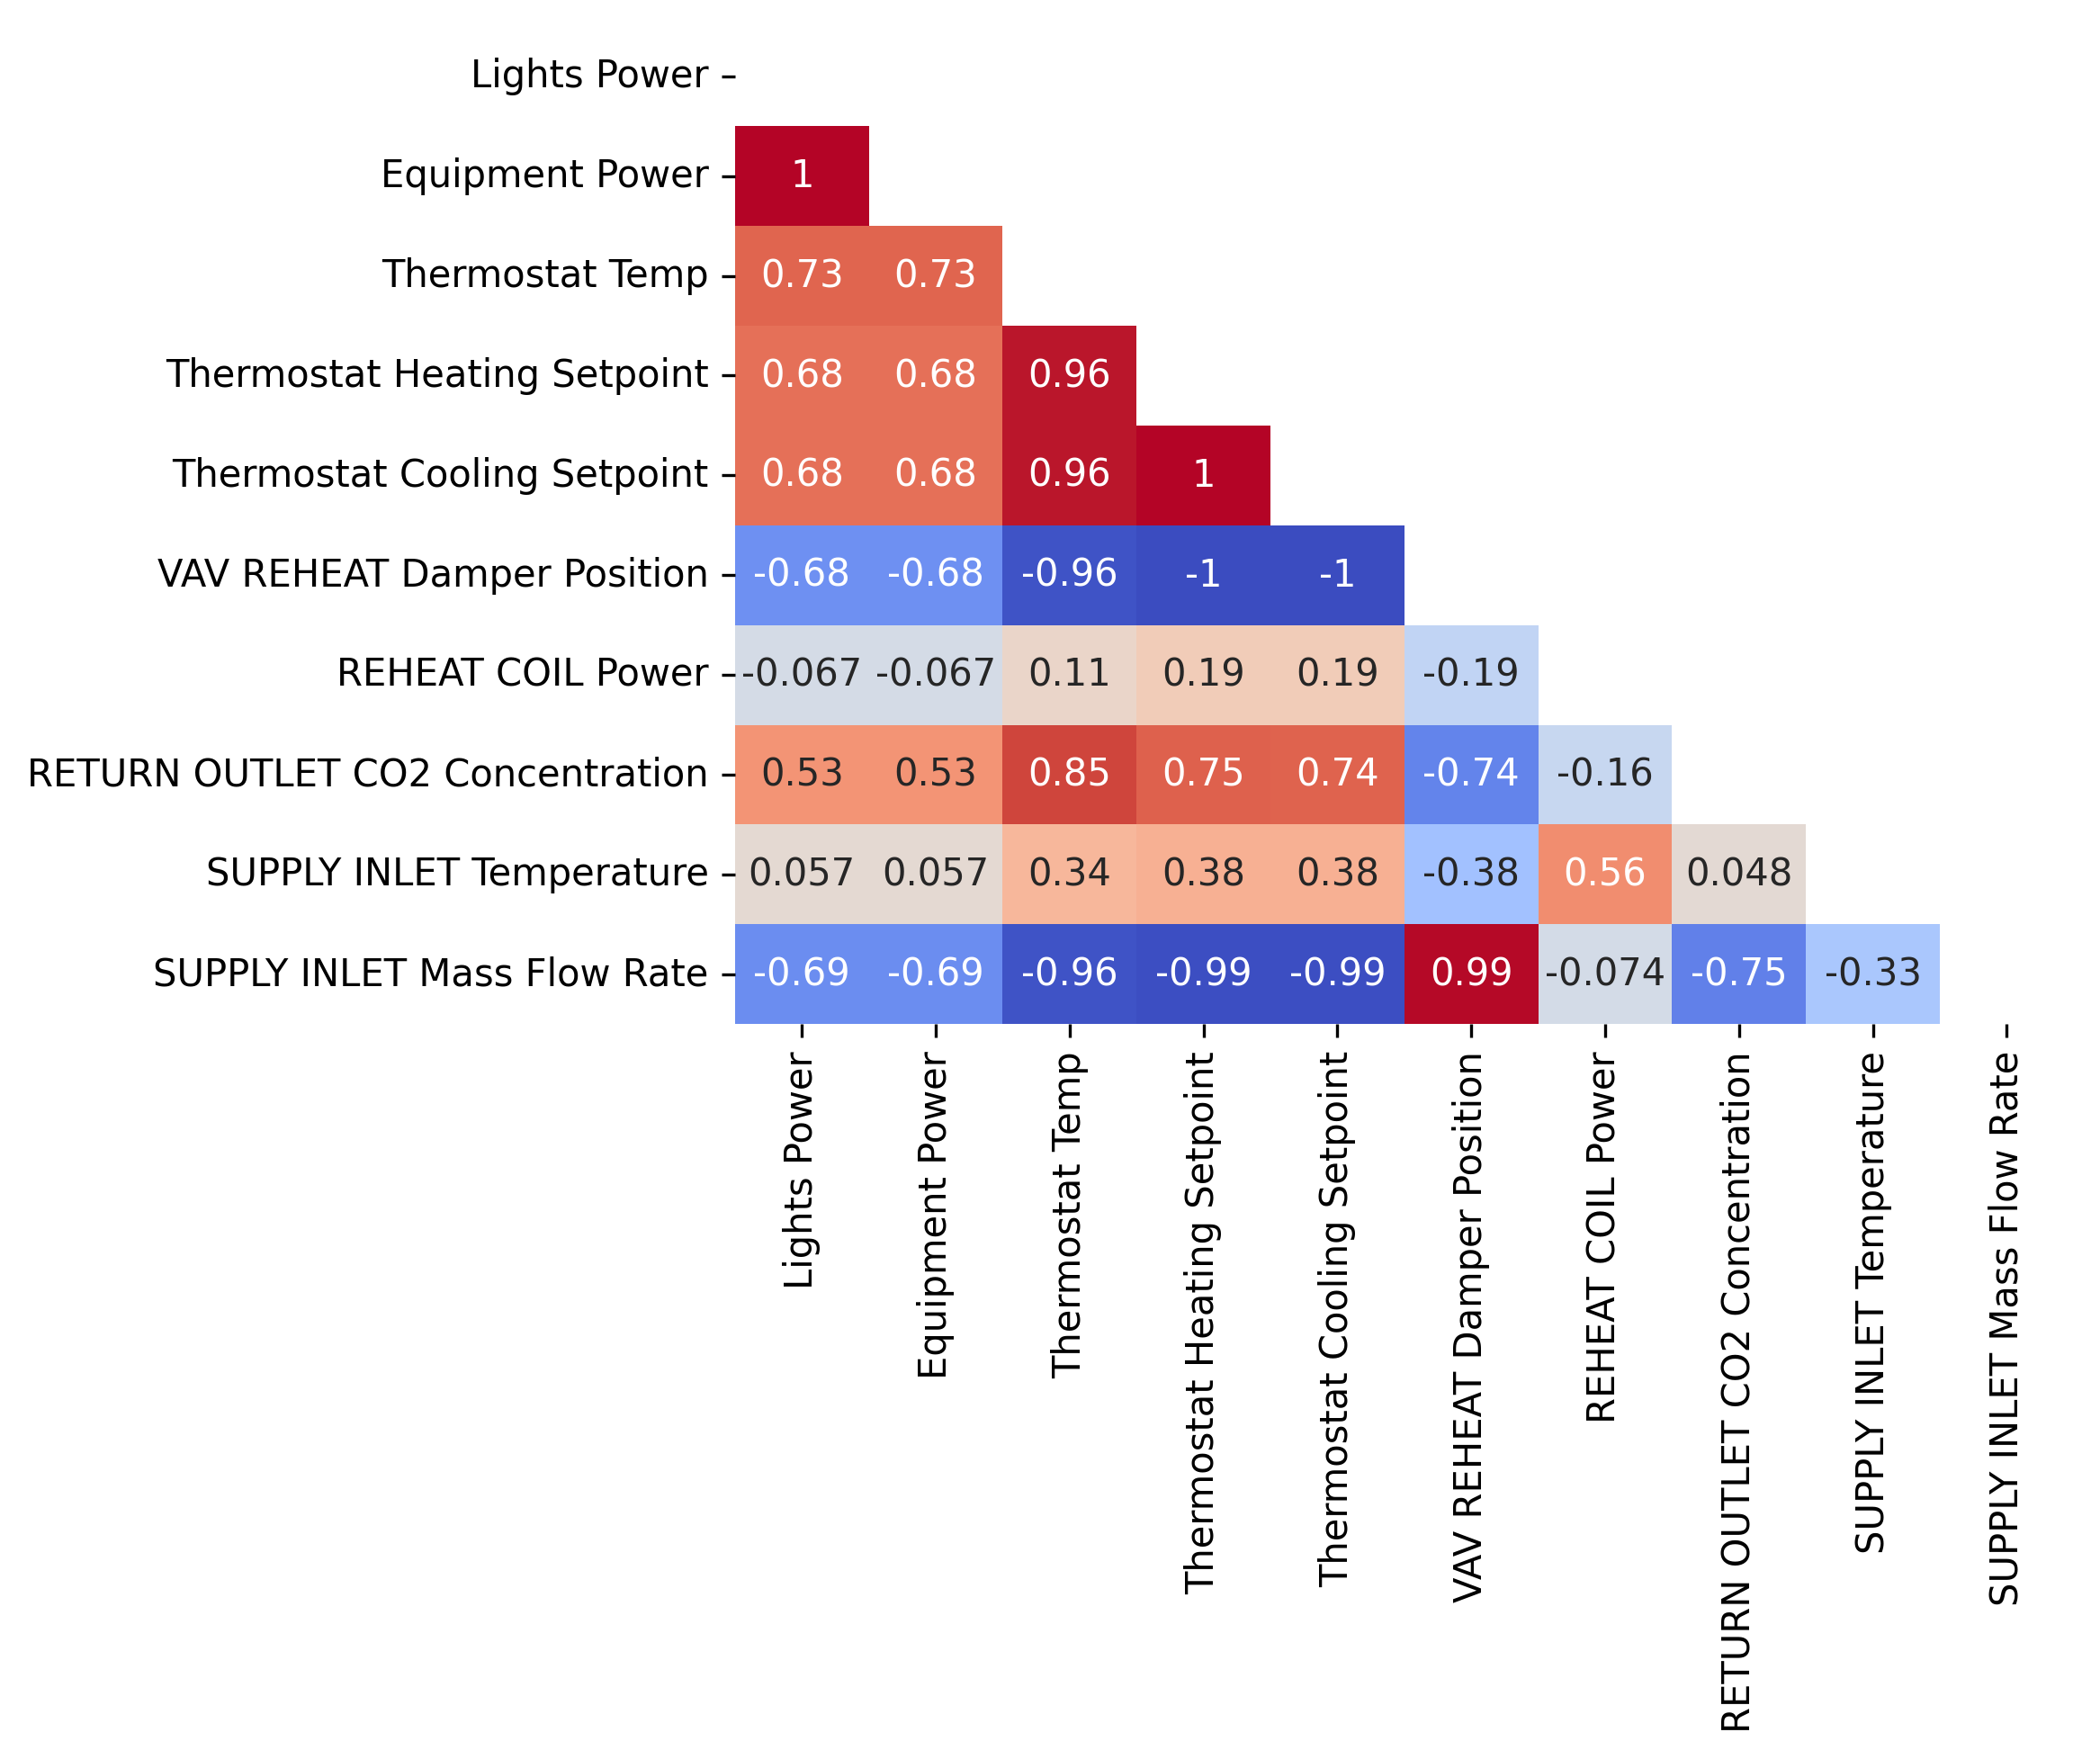

День 9

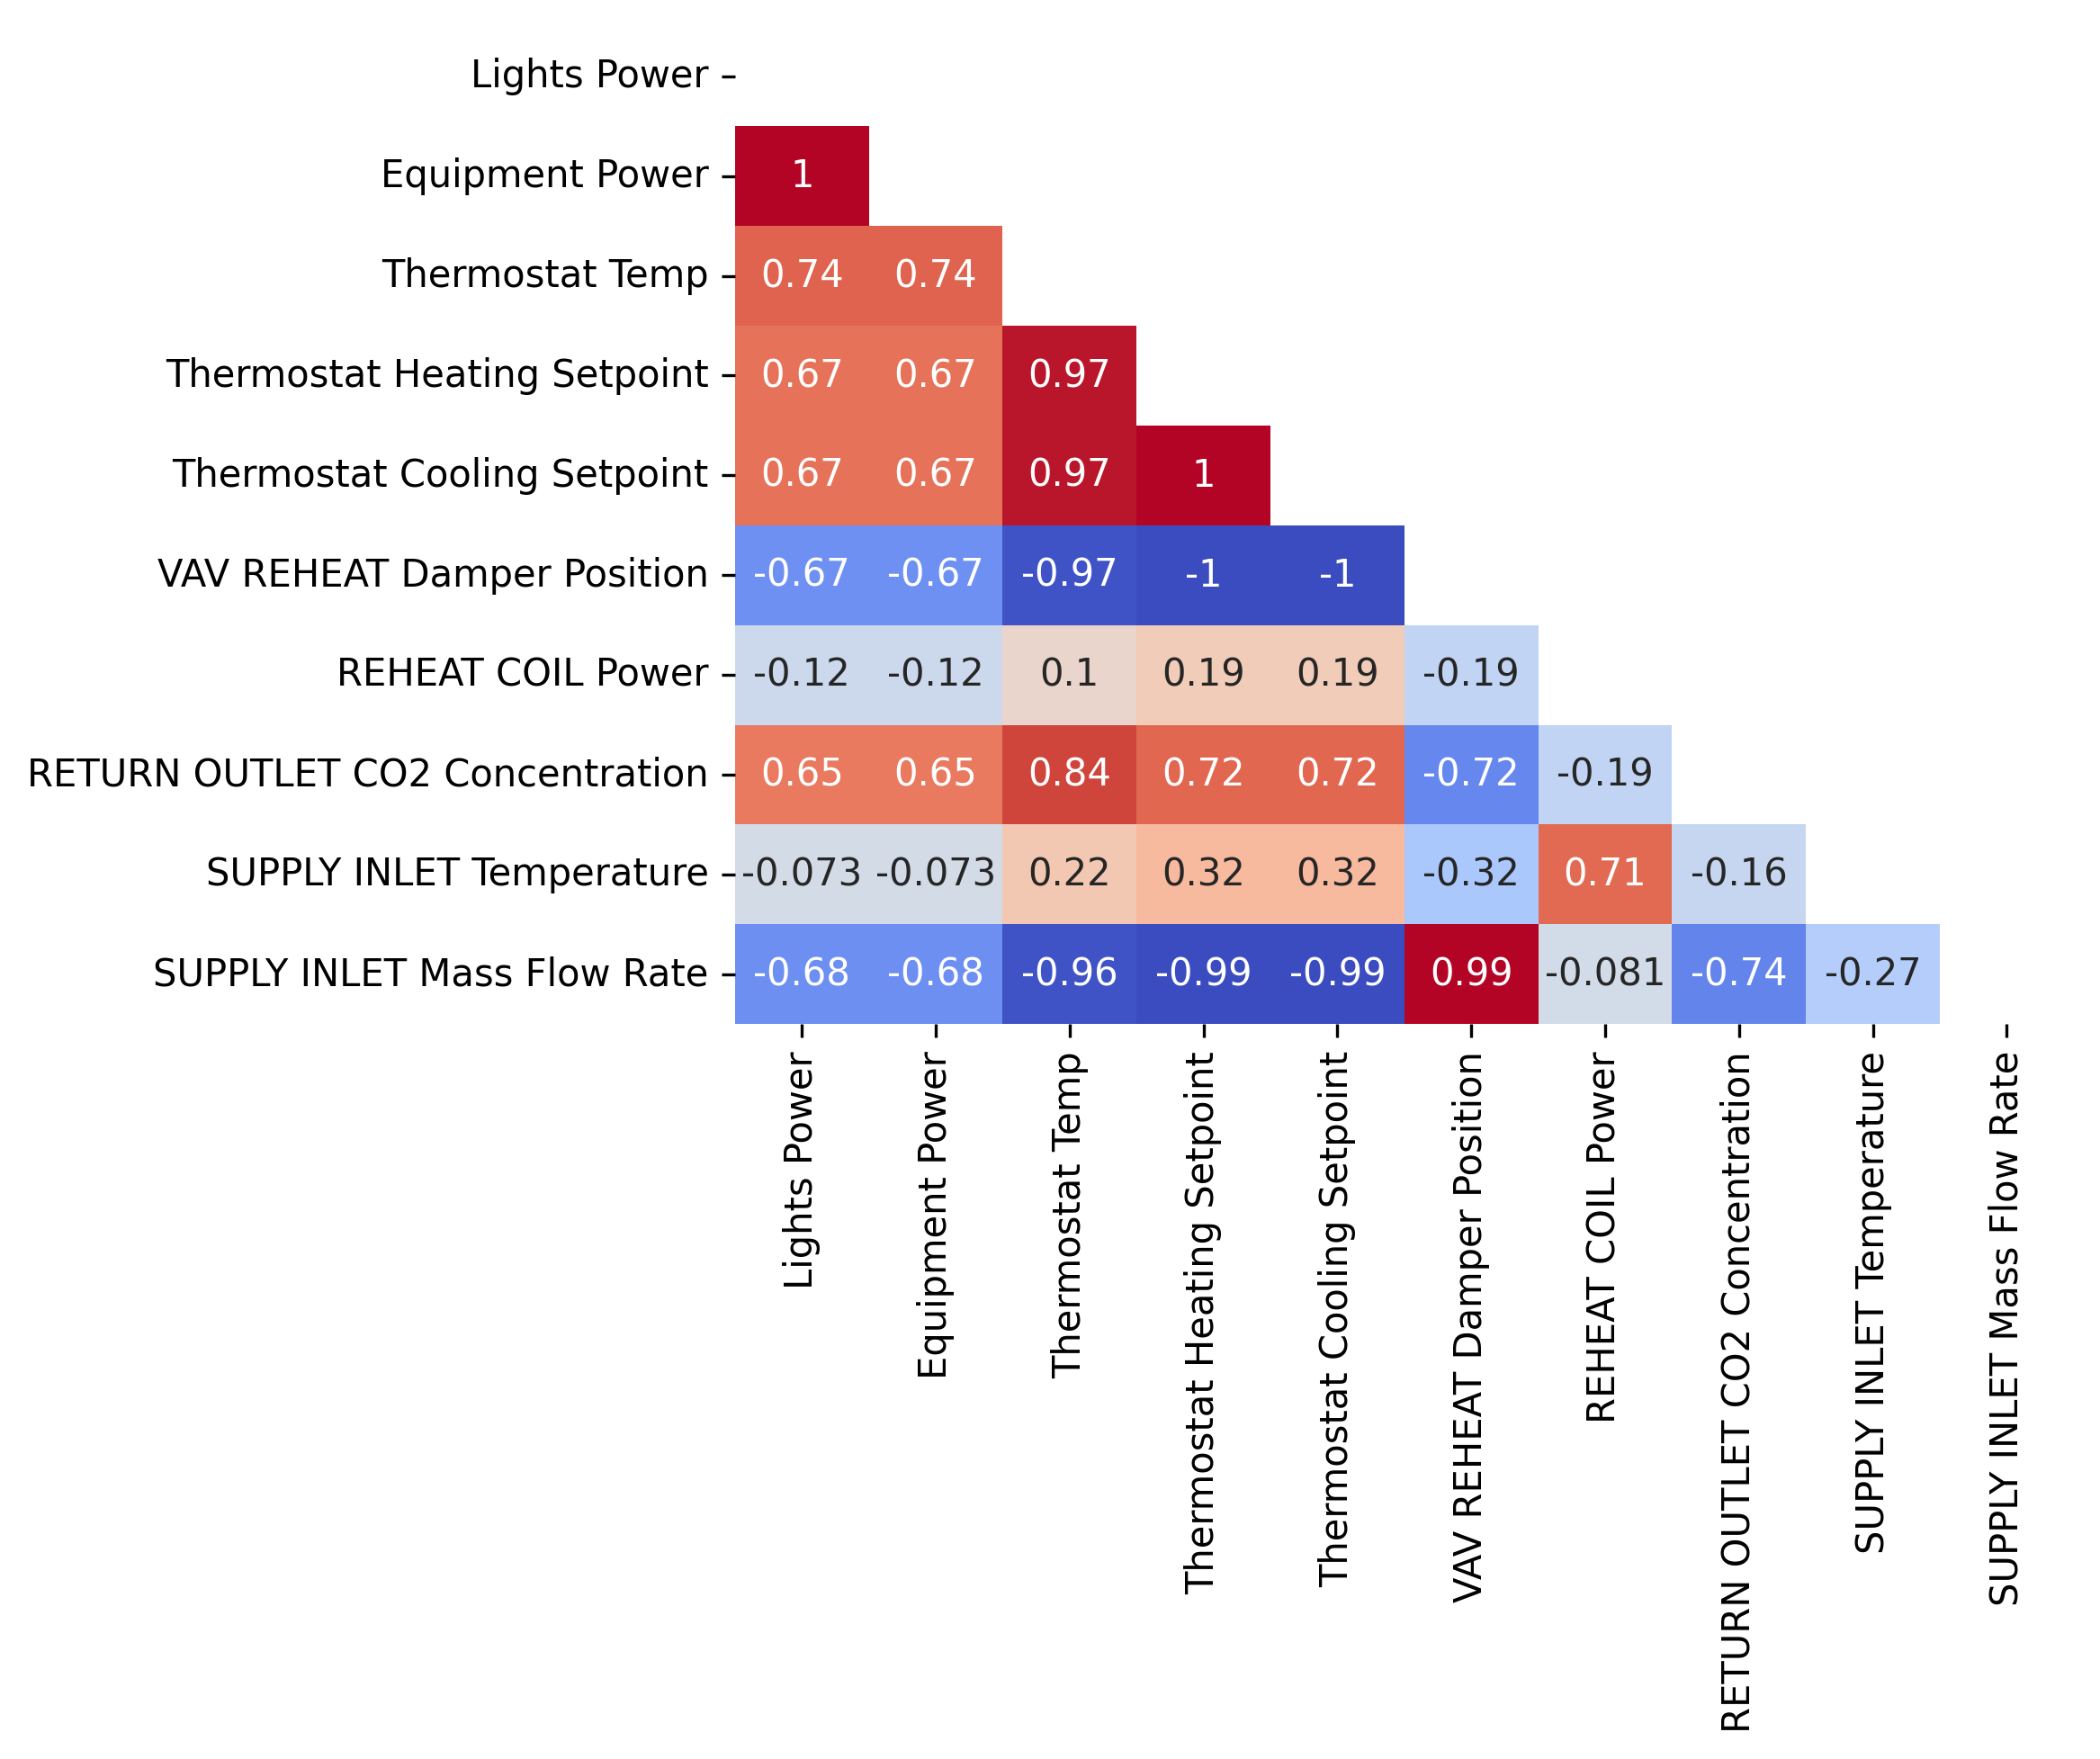

День 10

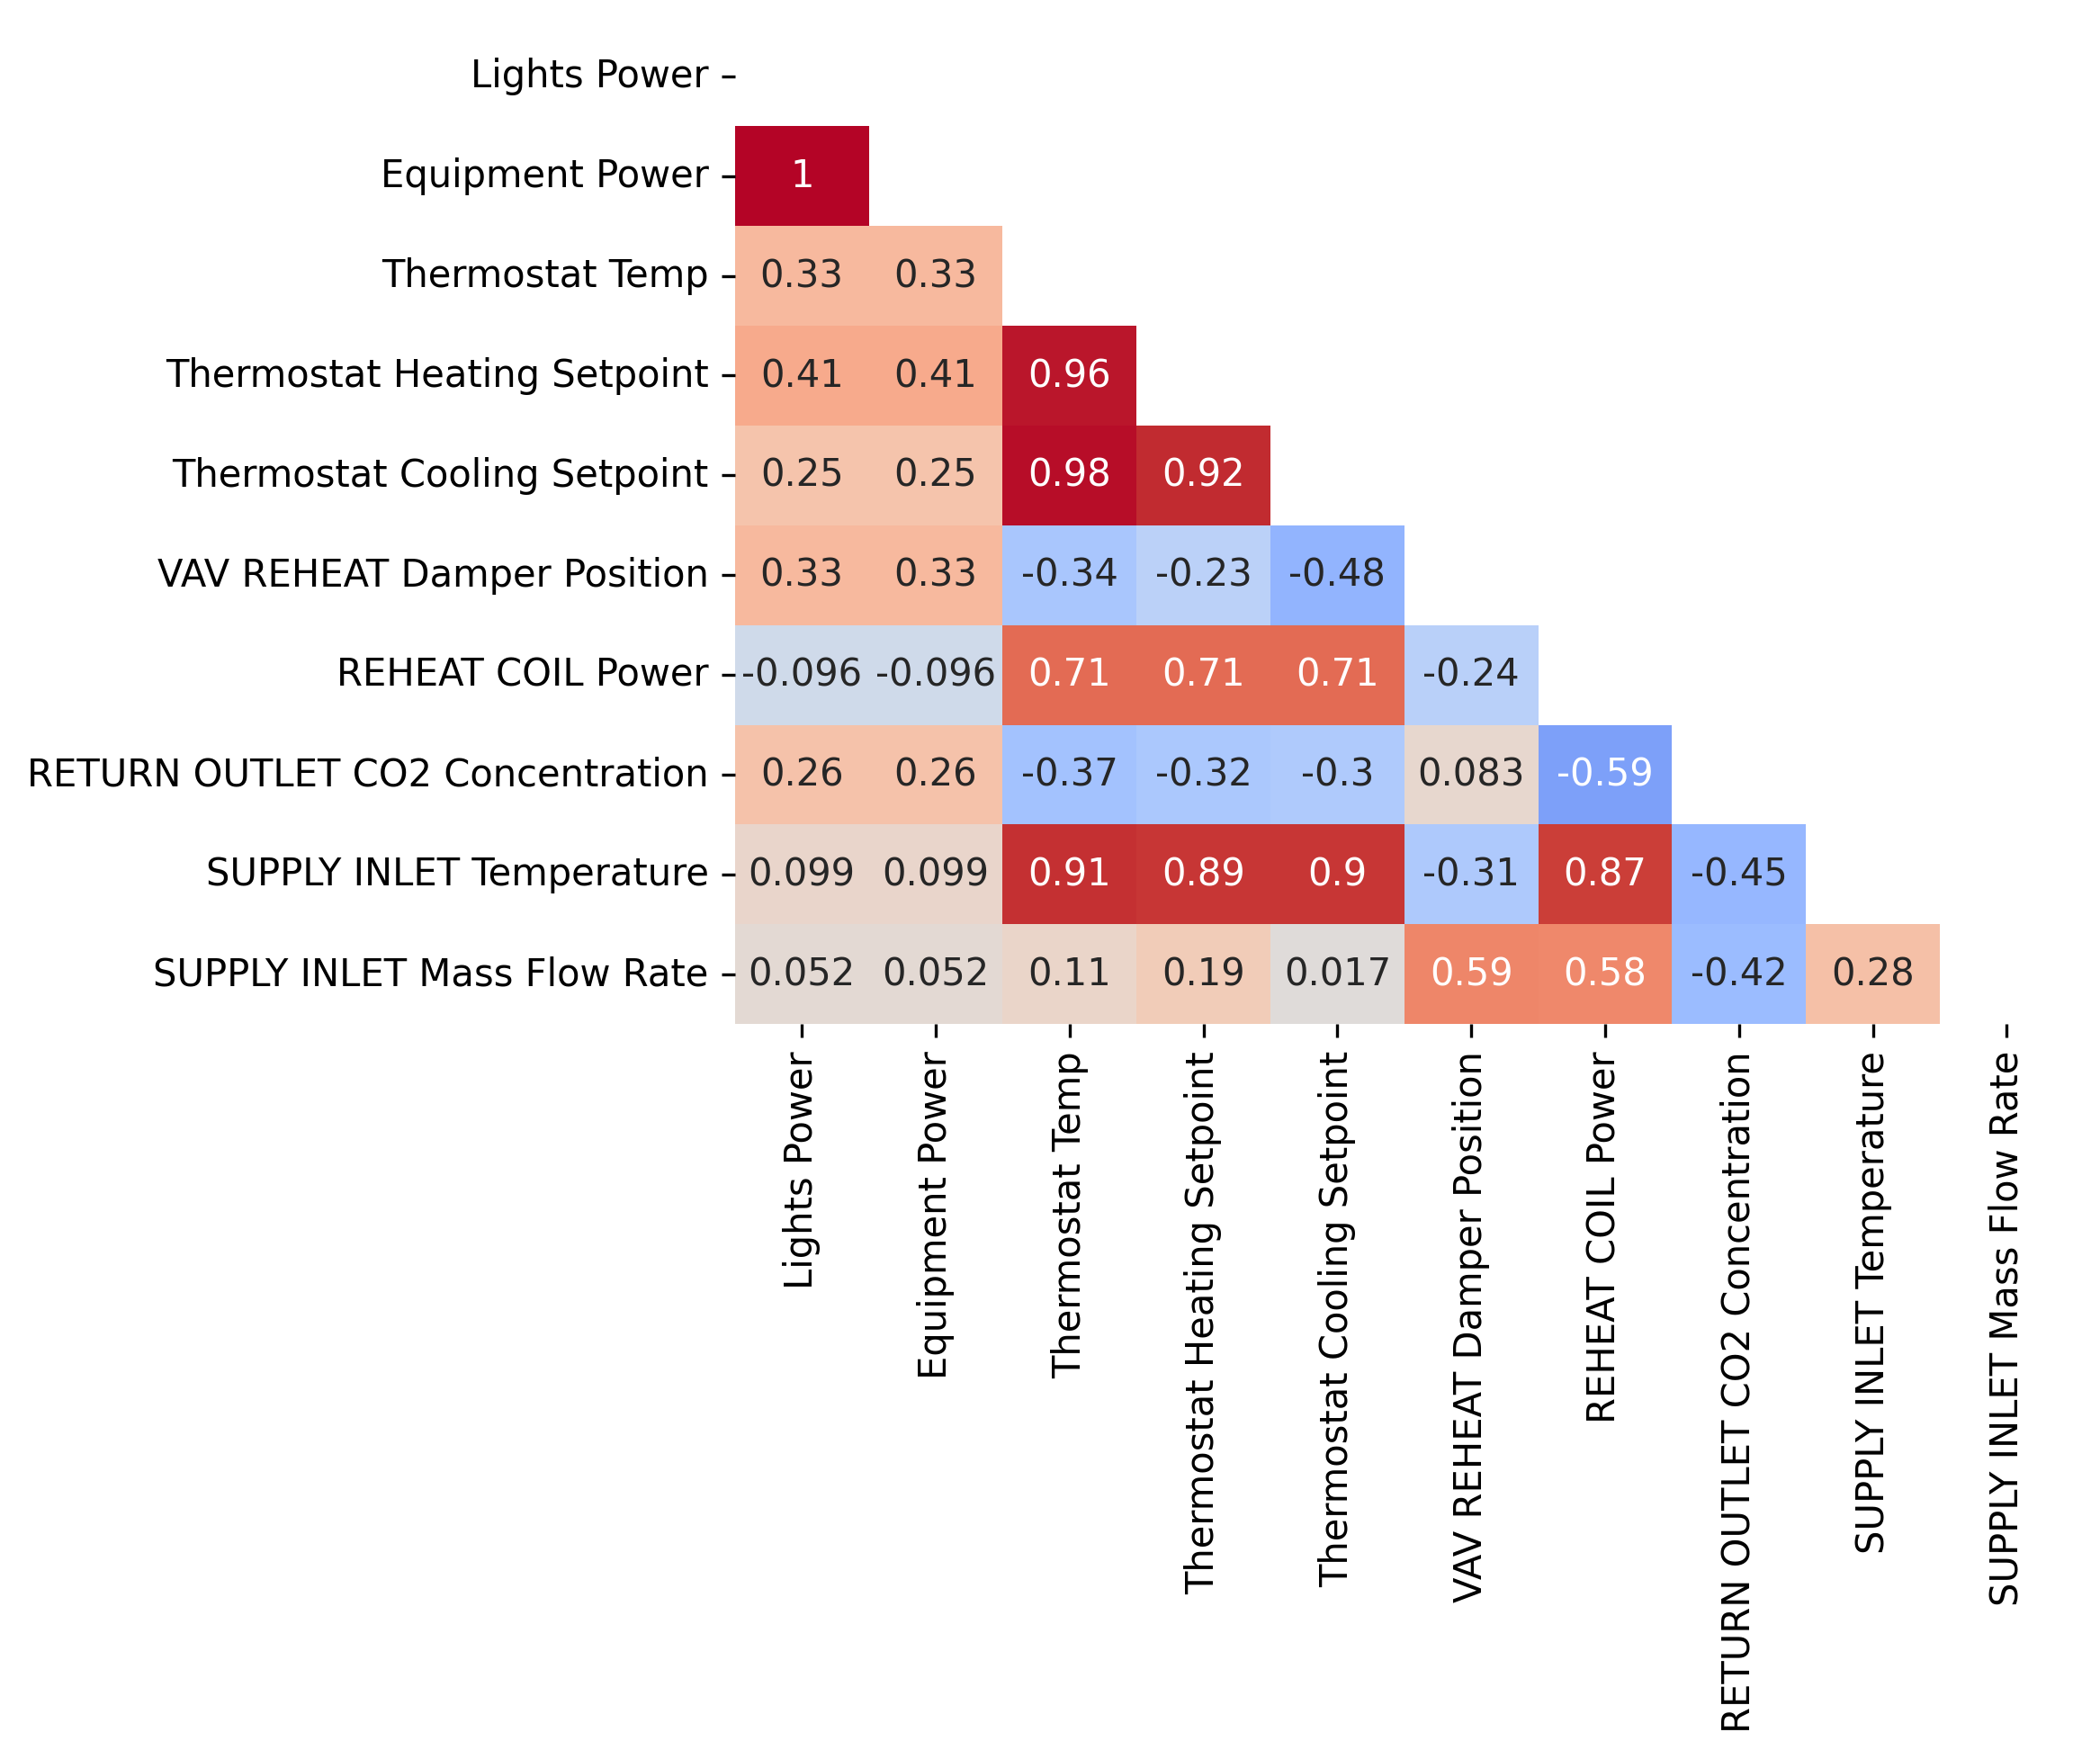

День 11

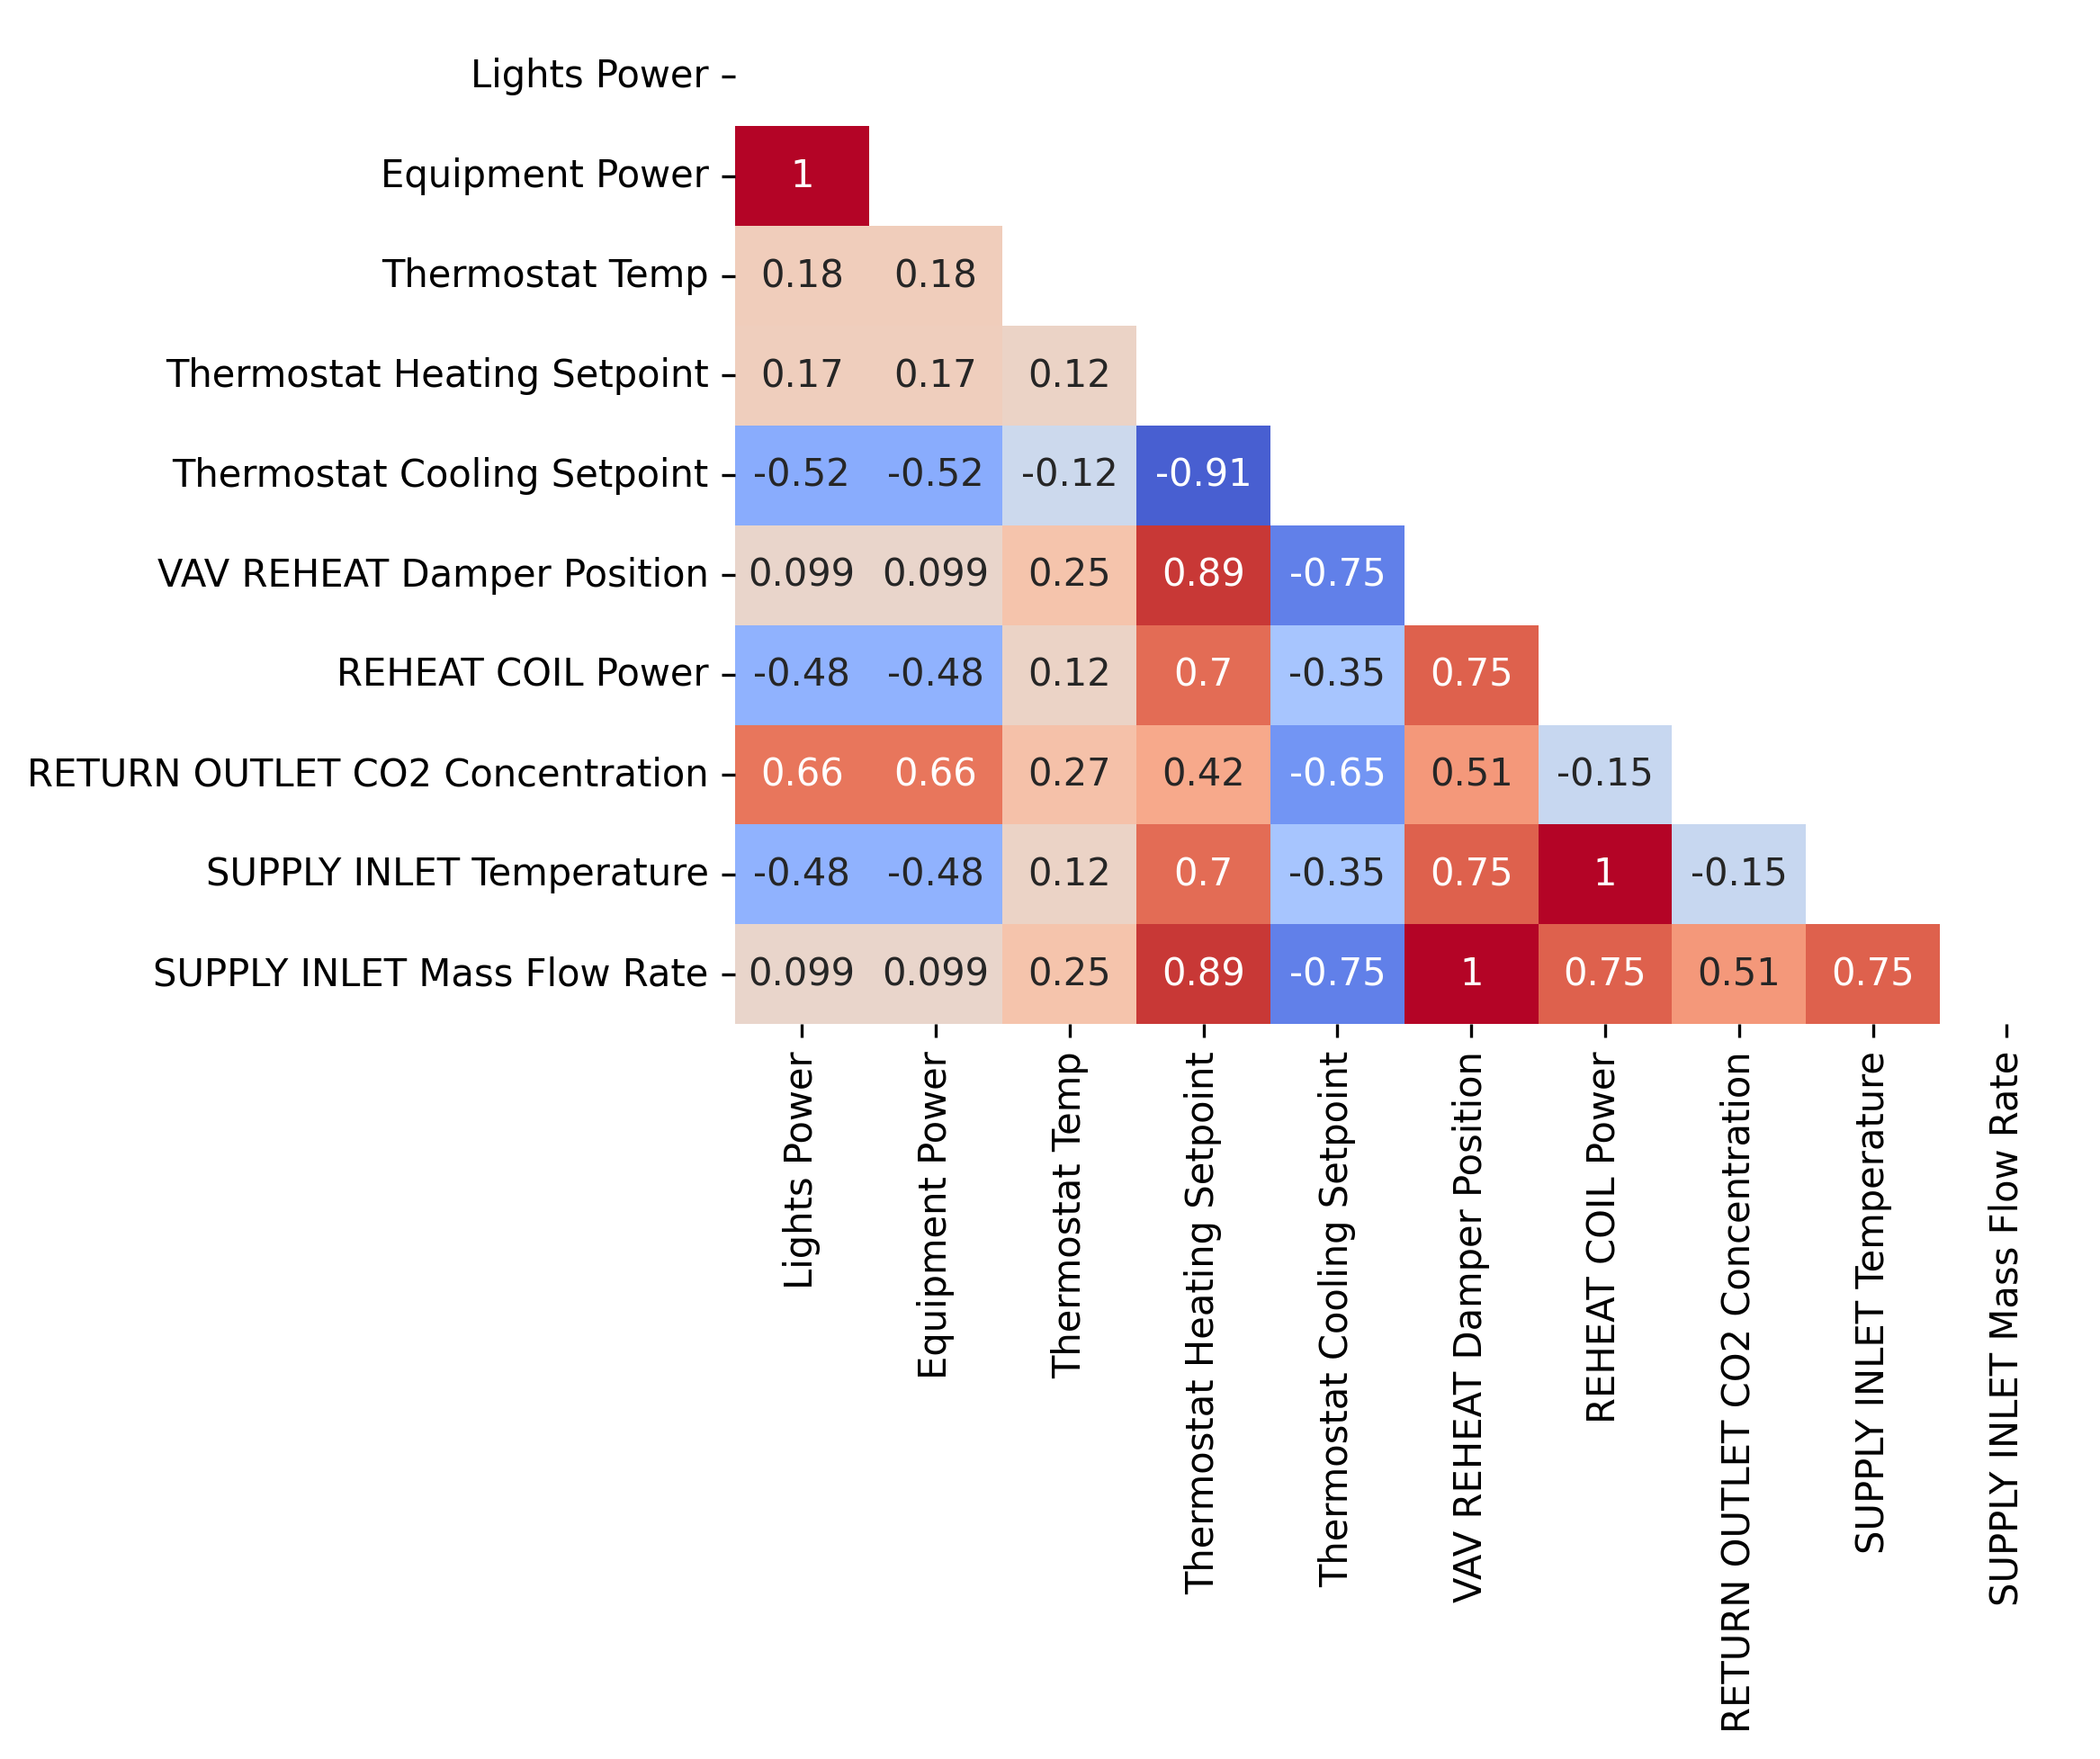

День 12

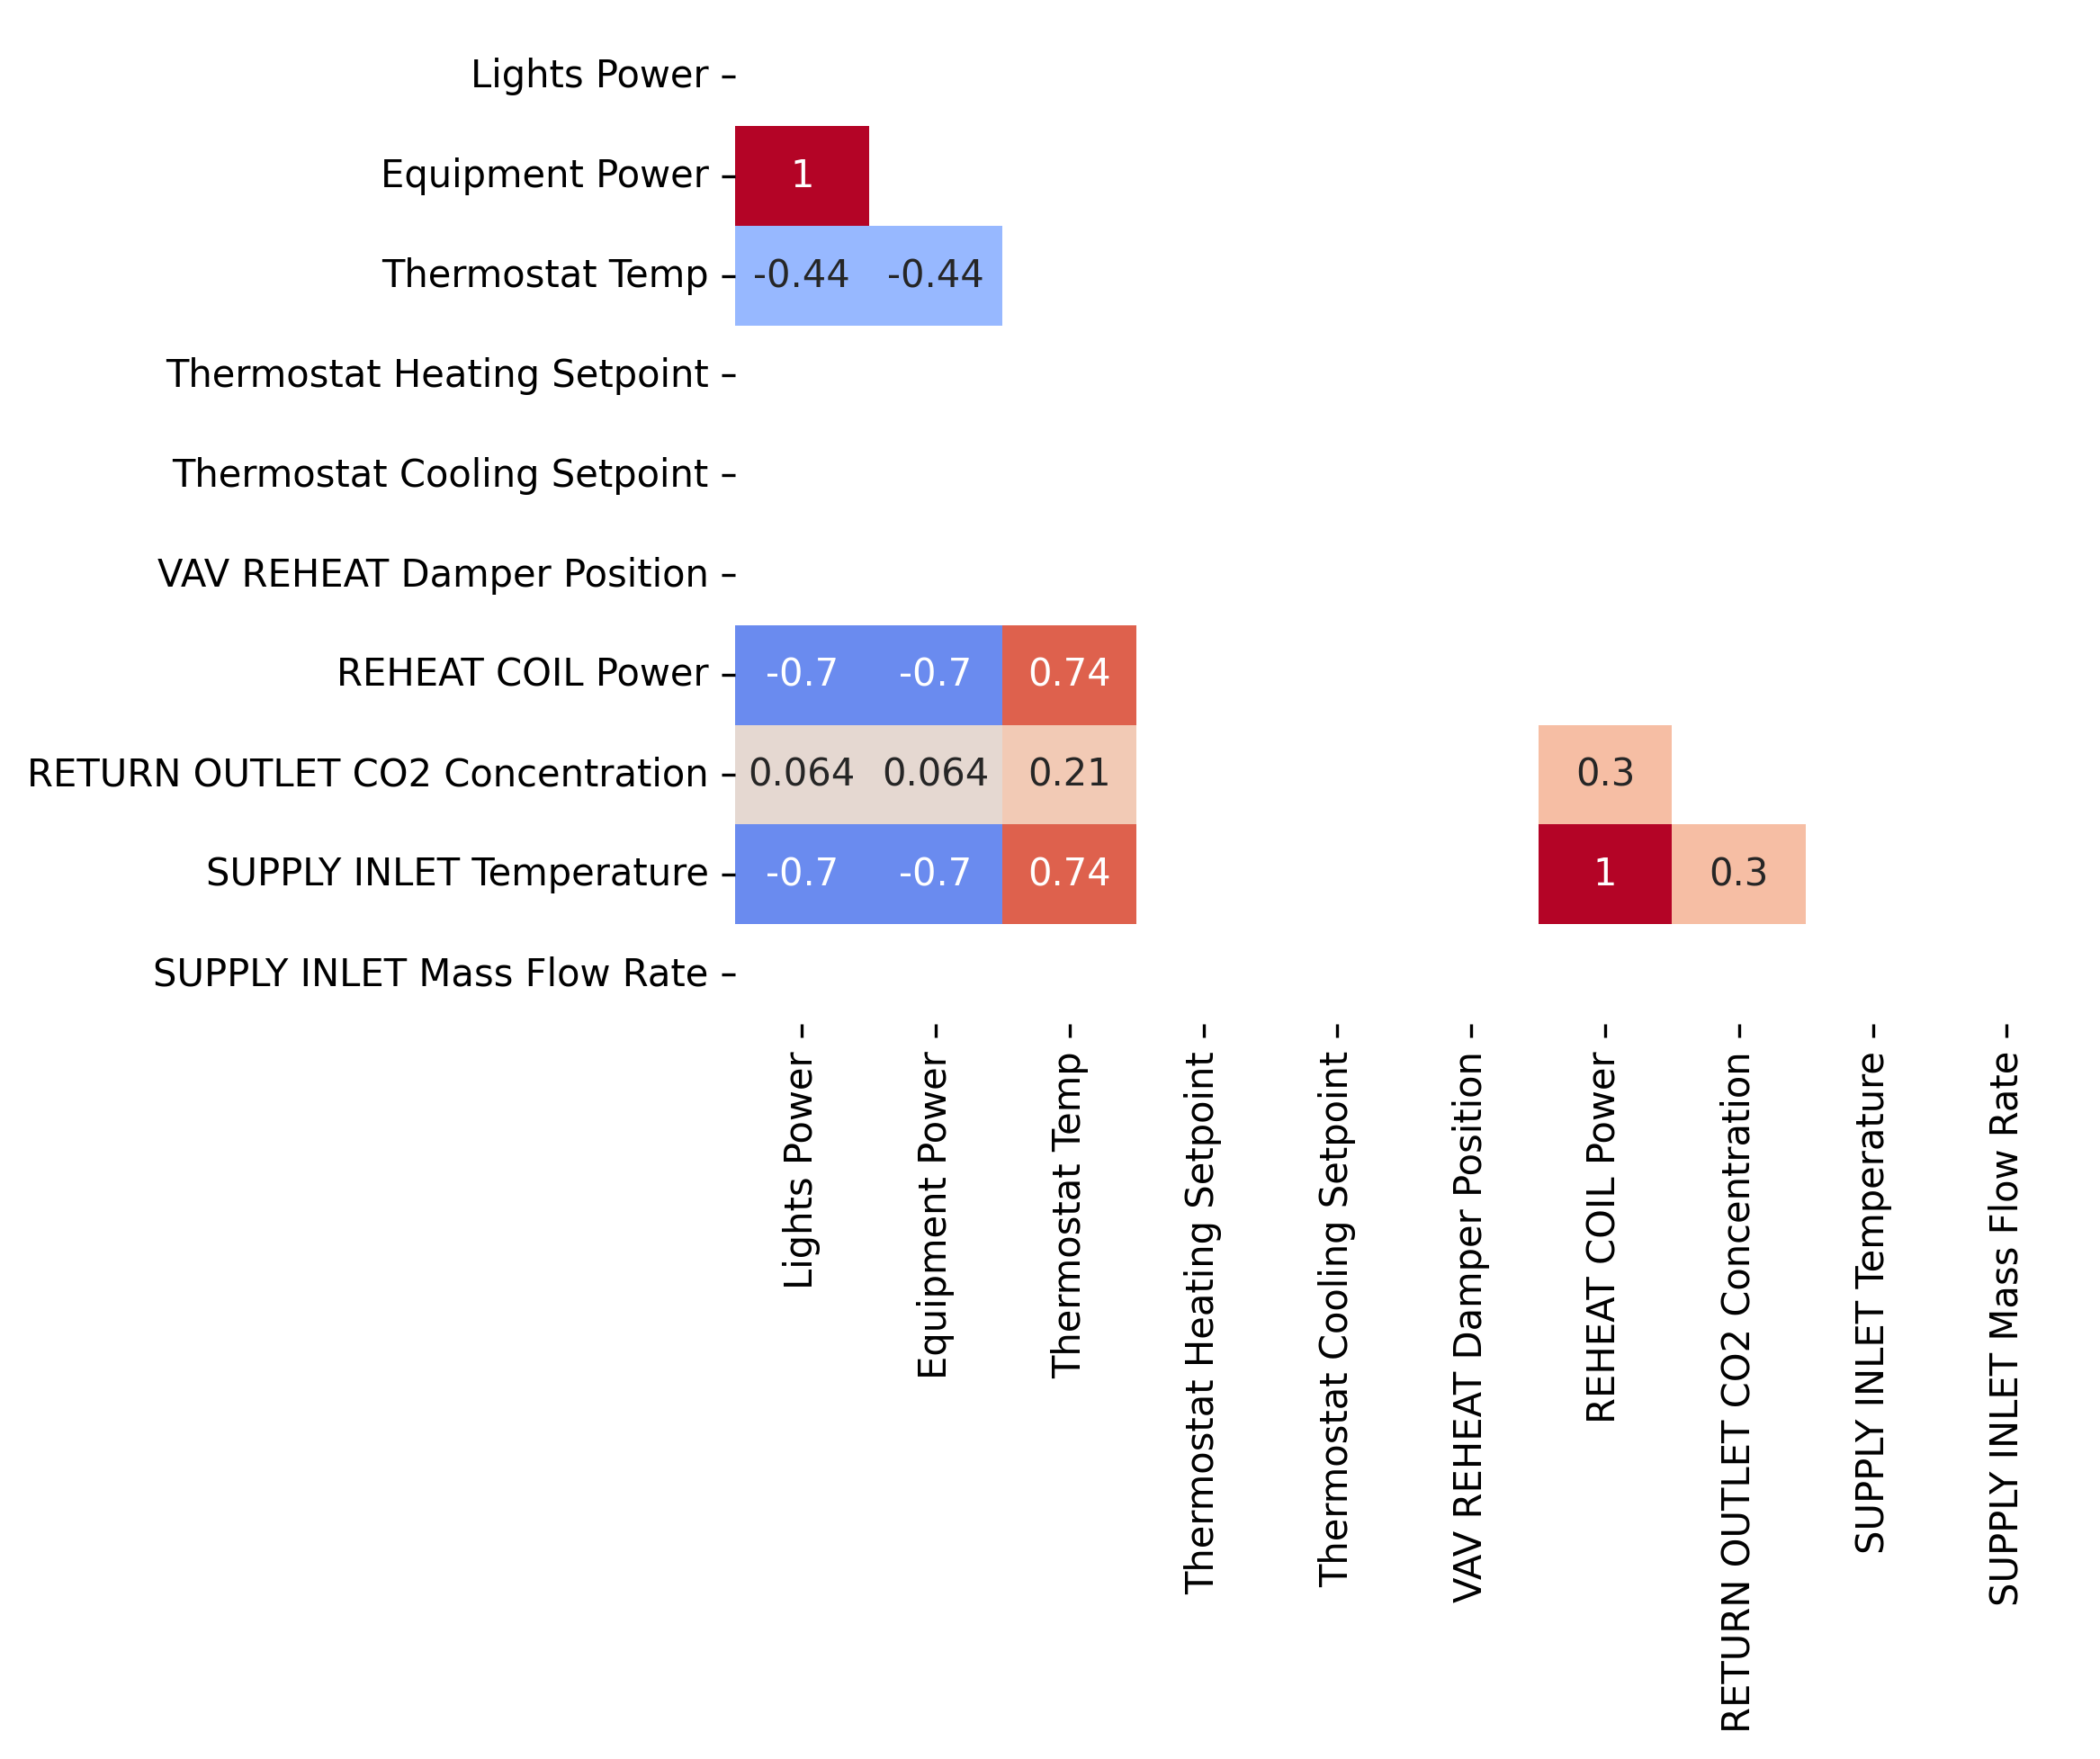

День 13

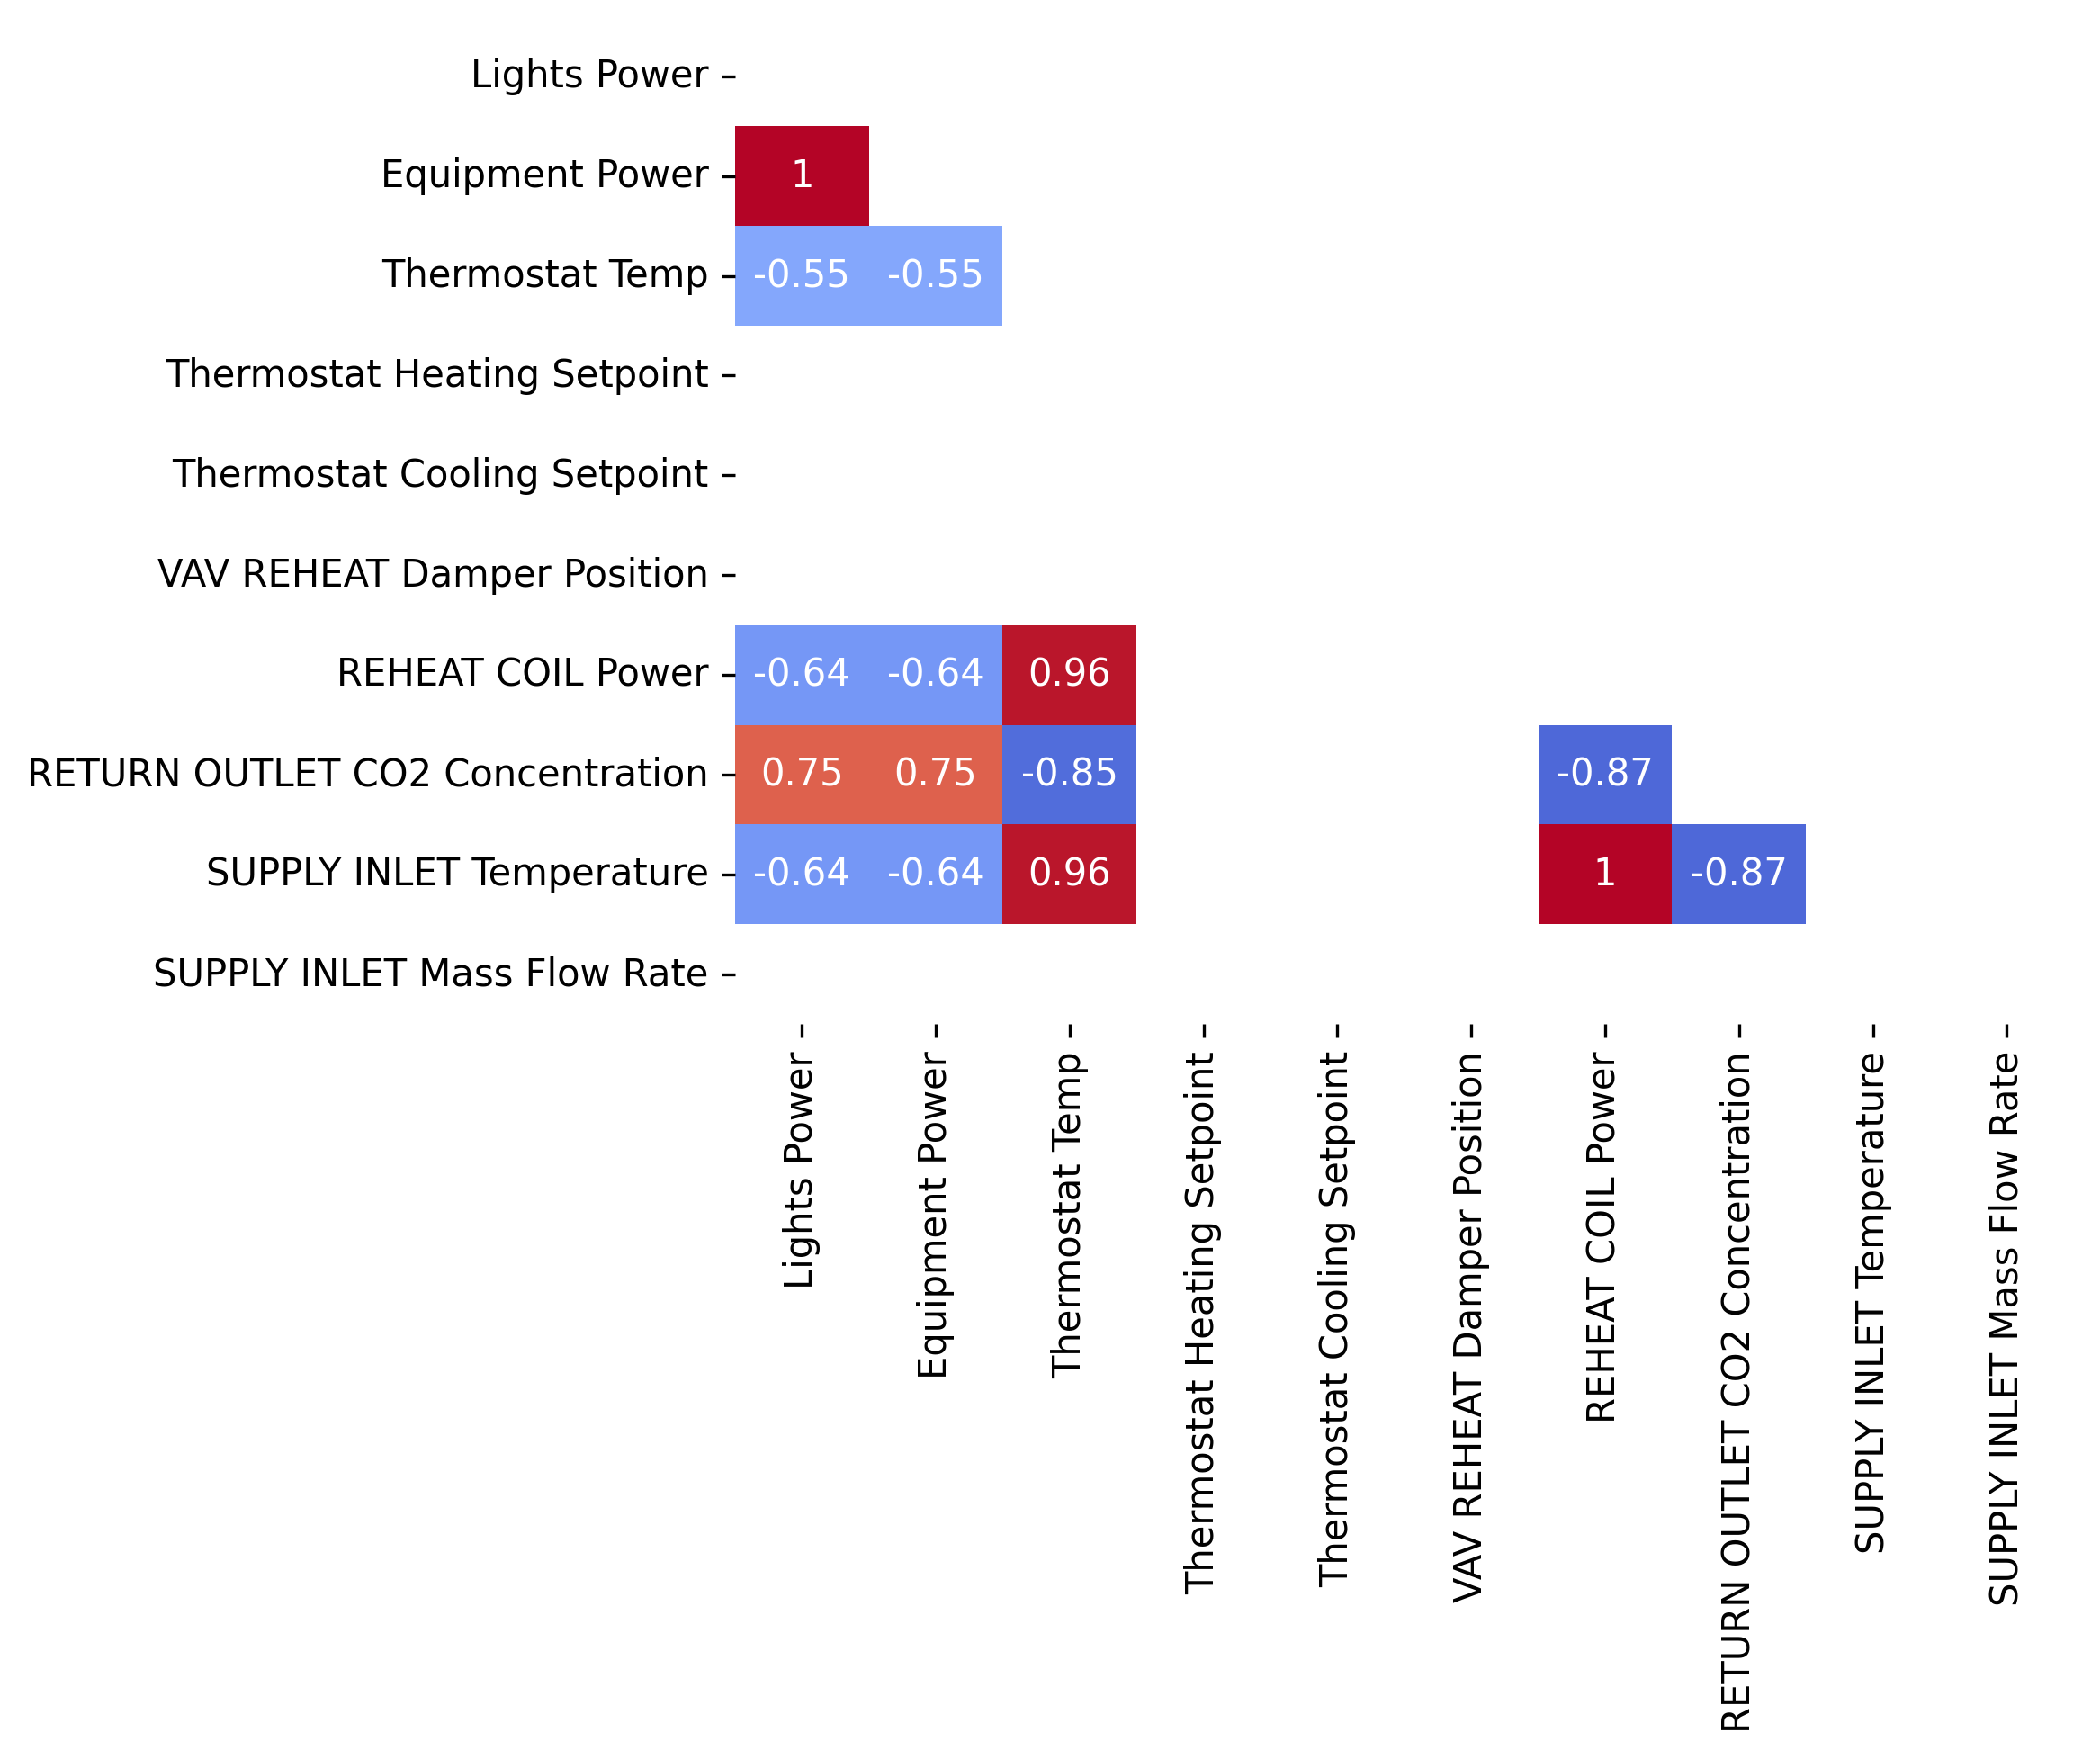

День 14

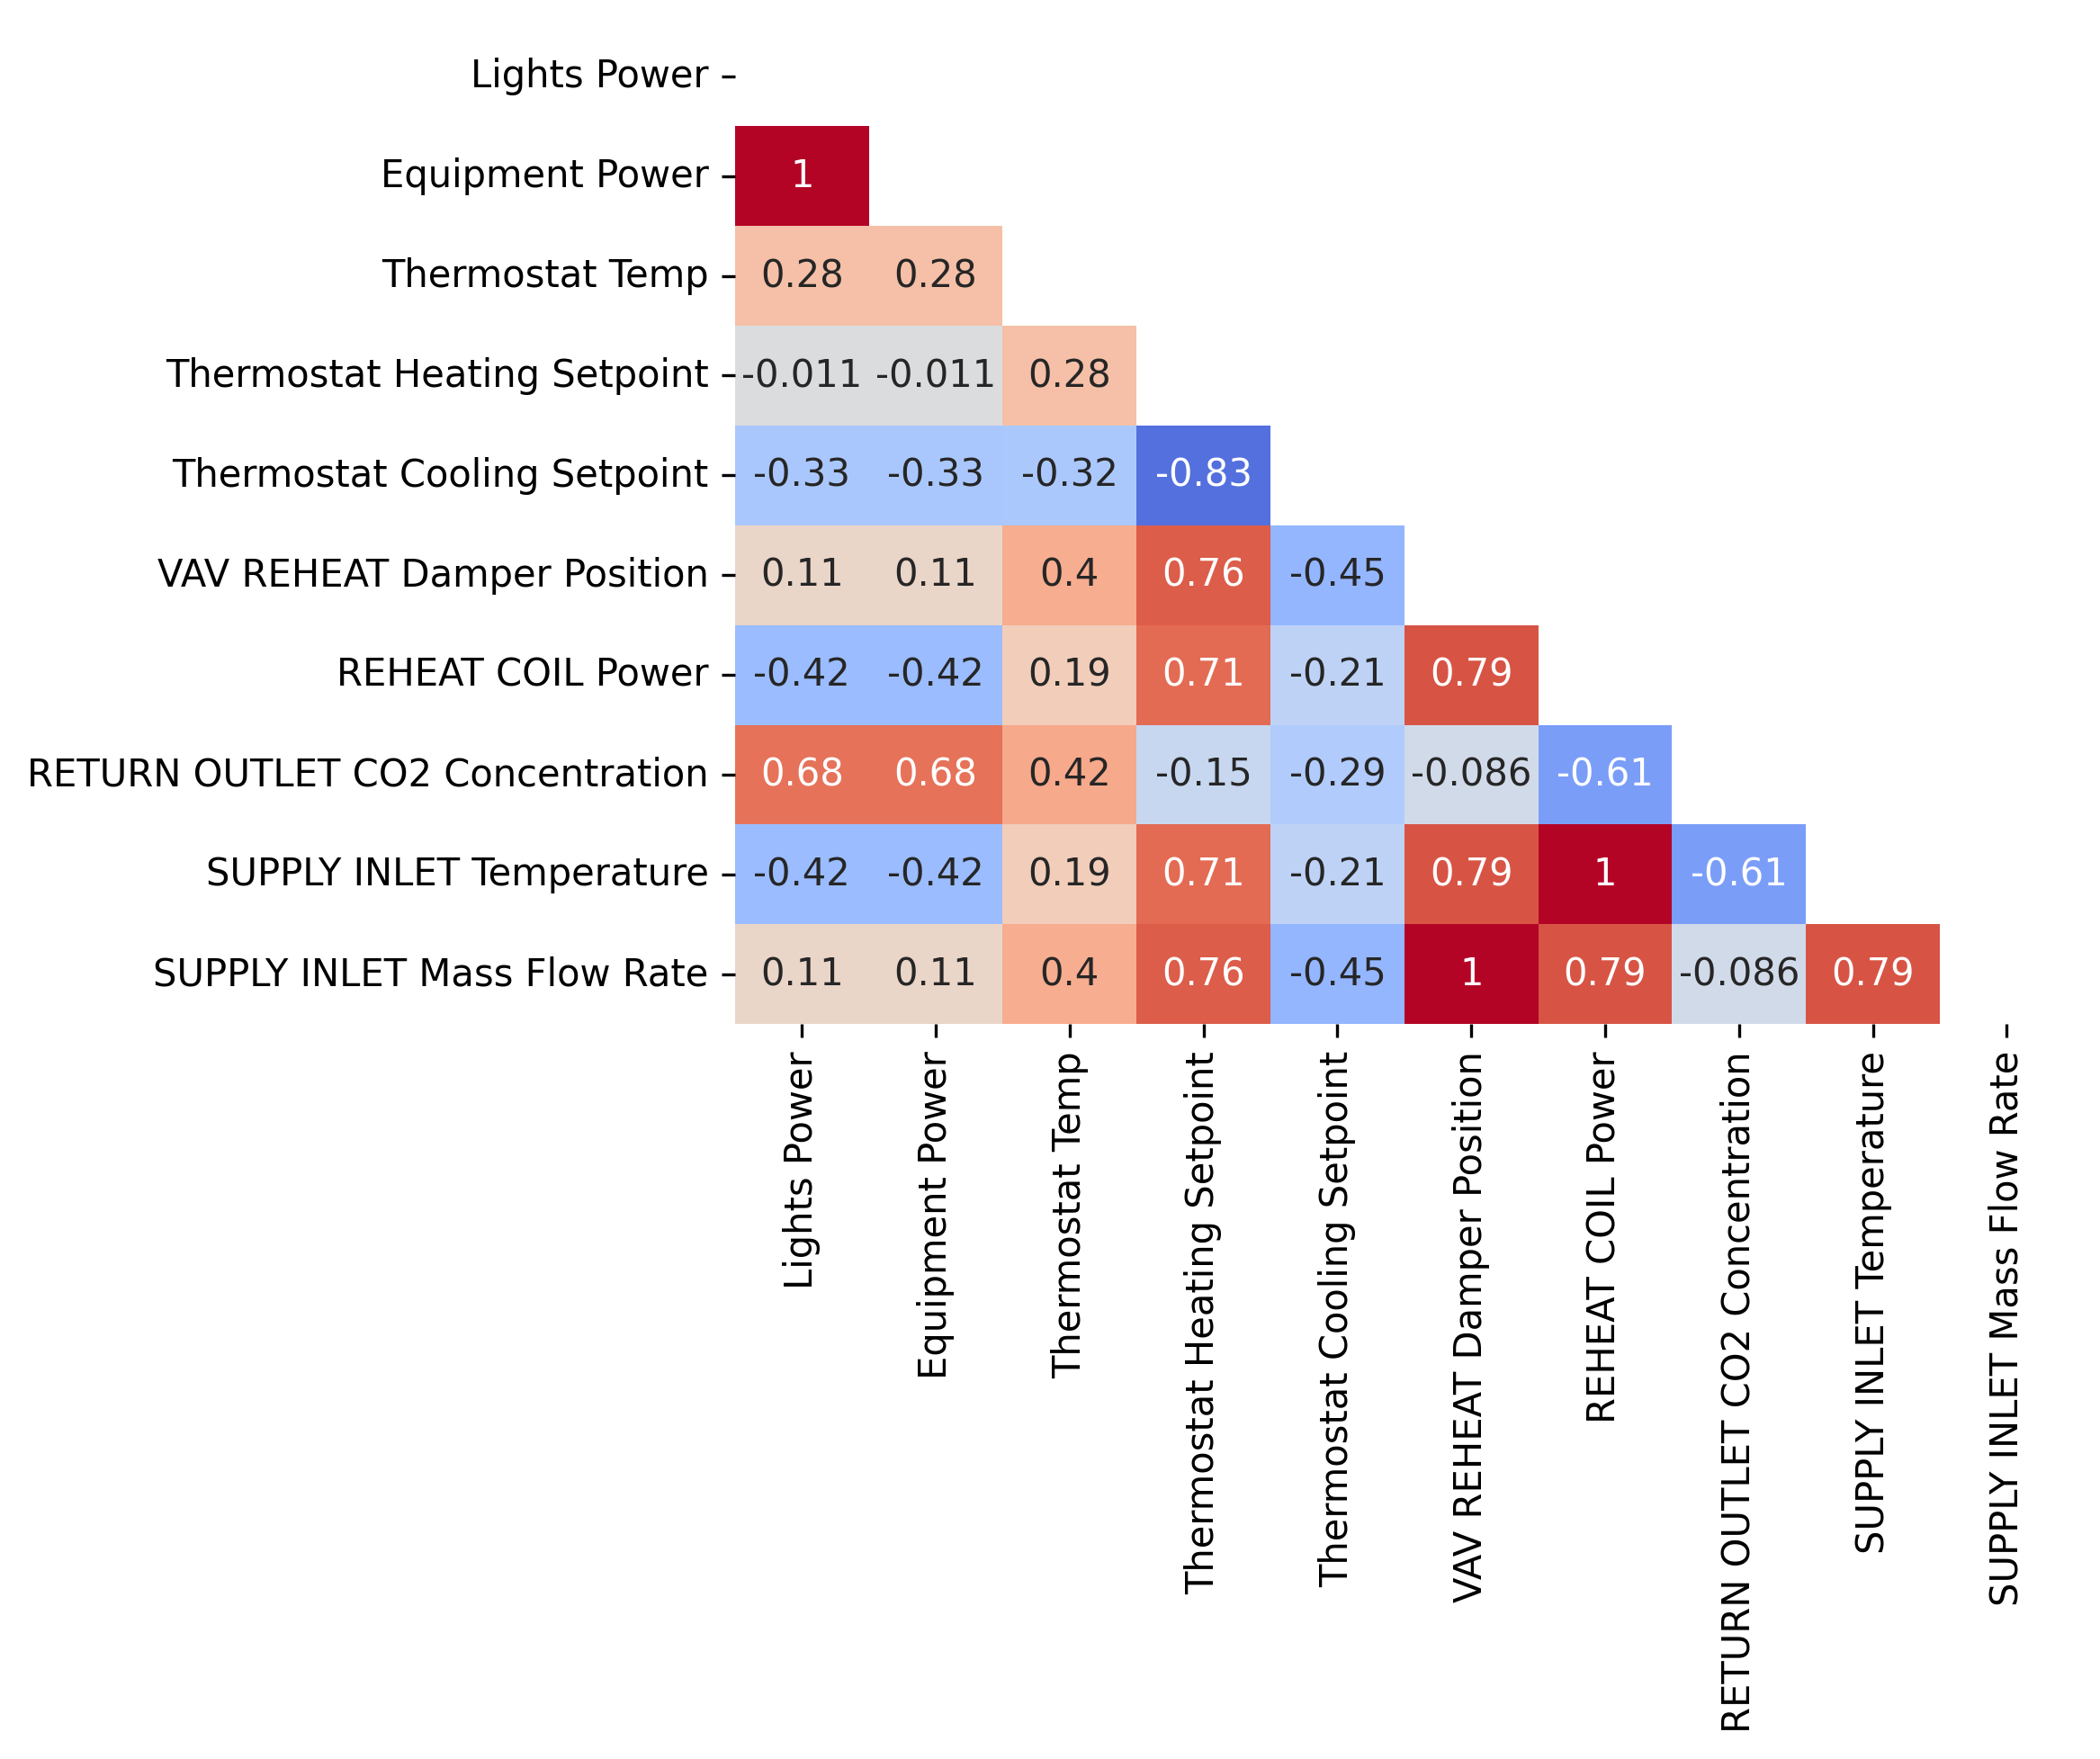

In [231]:
dfs_corr = [df.corr() for df in dfs]

for i, df_corr in enumerate(dfs_corr):
    fig, ax = plt.subplots()

    display(Markdown(f"День {i+1}"))

    mask = np.triu(np.ones_like(df_corr))

    _ = sns.heatmap(
            df_corr,
            cbar=False,
            ax=ax,
            annot=True,
            cmap='coolwarm',
            mask=mask,
            vmin=-1,
            vmax=1,
        )

    display(fig)

- Выберем те ячейки матрицы корреляции, которые в достаточной степени меняются в зависимости от дня:

In [232]:
corr_matrix_size = dfs_corr[0].shape
useful = np.full(corr_matrix_size, False)
useful_l = np.ndarray((0, Ndays))

# for i in range(len(dfs_corr)):
#     dfs_corr[i] = dfs_corr[i].fillna(0)

import itertools
from functools import reduce

def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

for pos in itertools.combinations_with_replacement(range(10), 2):
    elms = [df_corr.iat[pos] for df_corr in dfs_corr]

    mean = np.mean(elms)

    # print(elms)

    useful[pos] = reduce(lambda res, el: res or (abs(el - mean) > 0.1), elms, False)

    if useful[pos]:
        useful_l = np.append(useful_l, [norm(elms)], axis=0)
        print(dfs_corr[0].keys()[pos[0]], dfs_corr[0].index[pos[1]], sep=', ')

Thermostat Temp, RETURN OUTLET CO2 Concentration
Thermostat Temp, SUPPLY INLET Temperature
RETURN OUTLET CO2 Concentration, SUPPLY INLET Temperature


Наконец, построим лица Чернова для каждого дня.

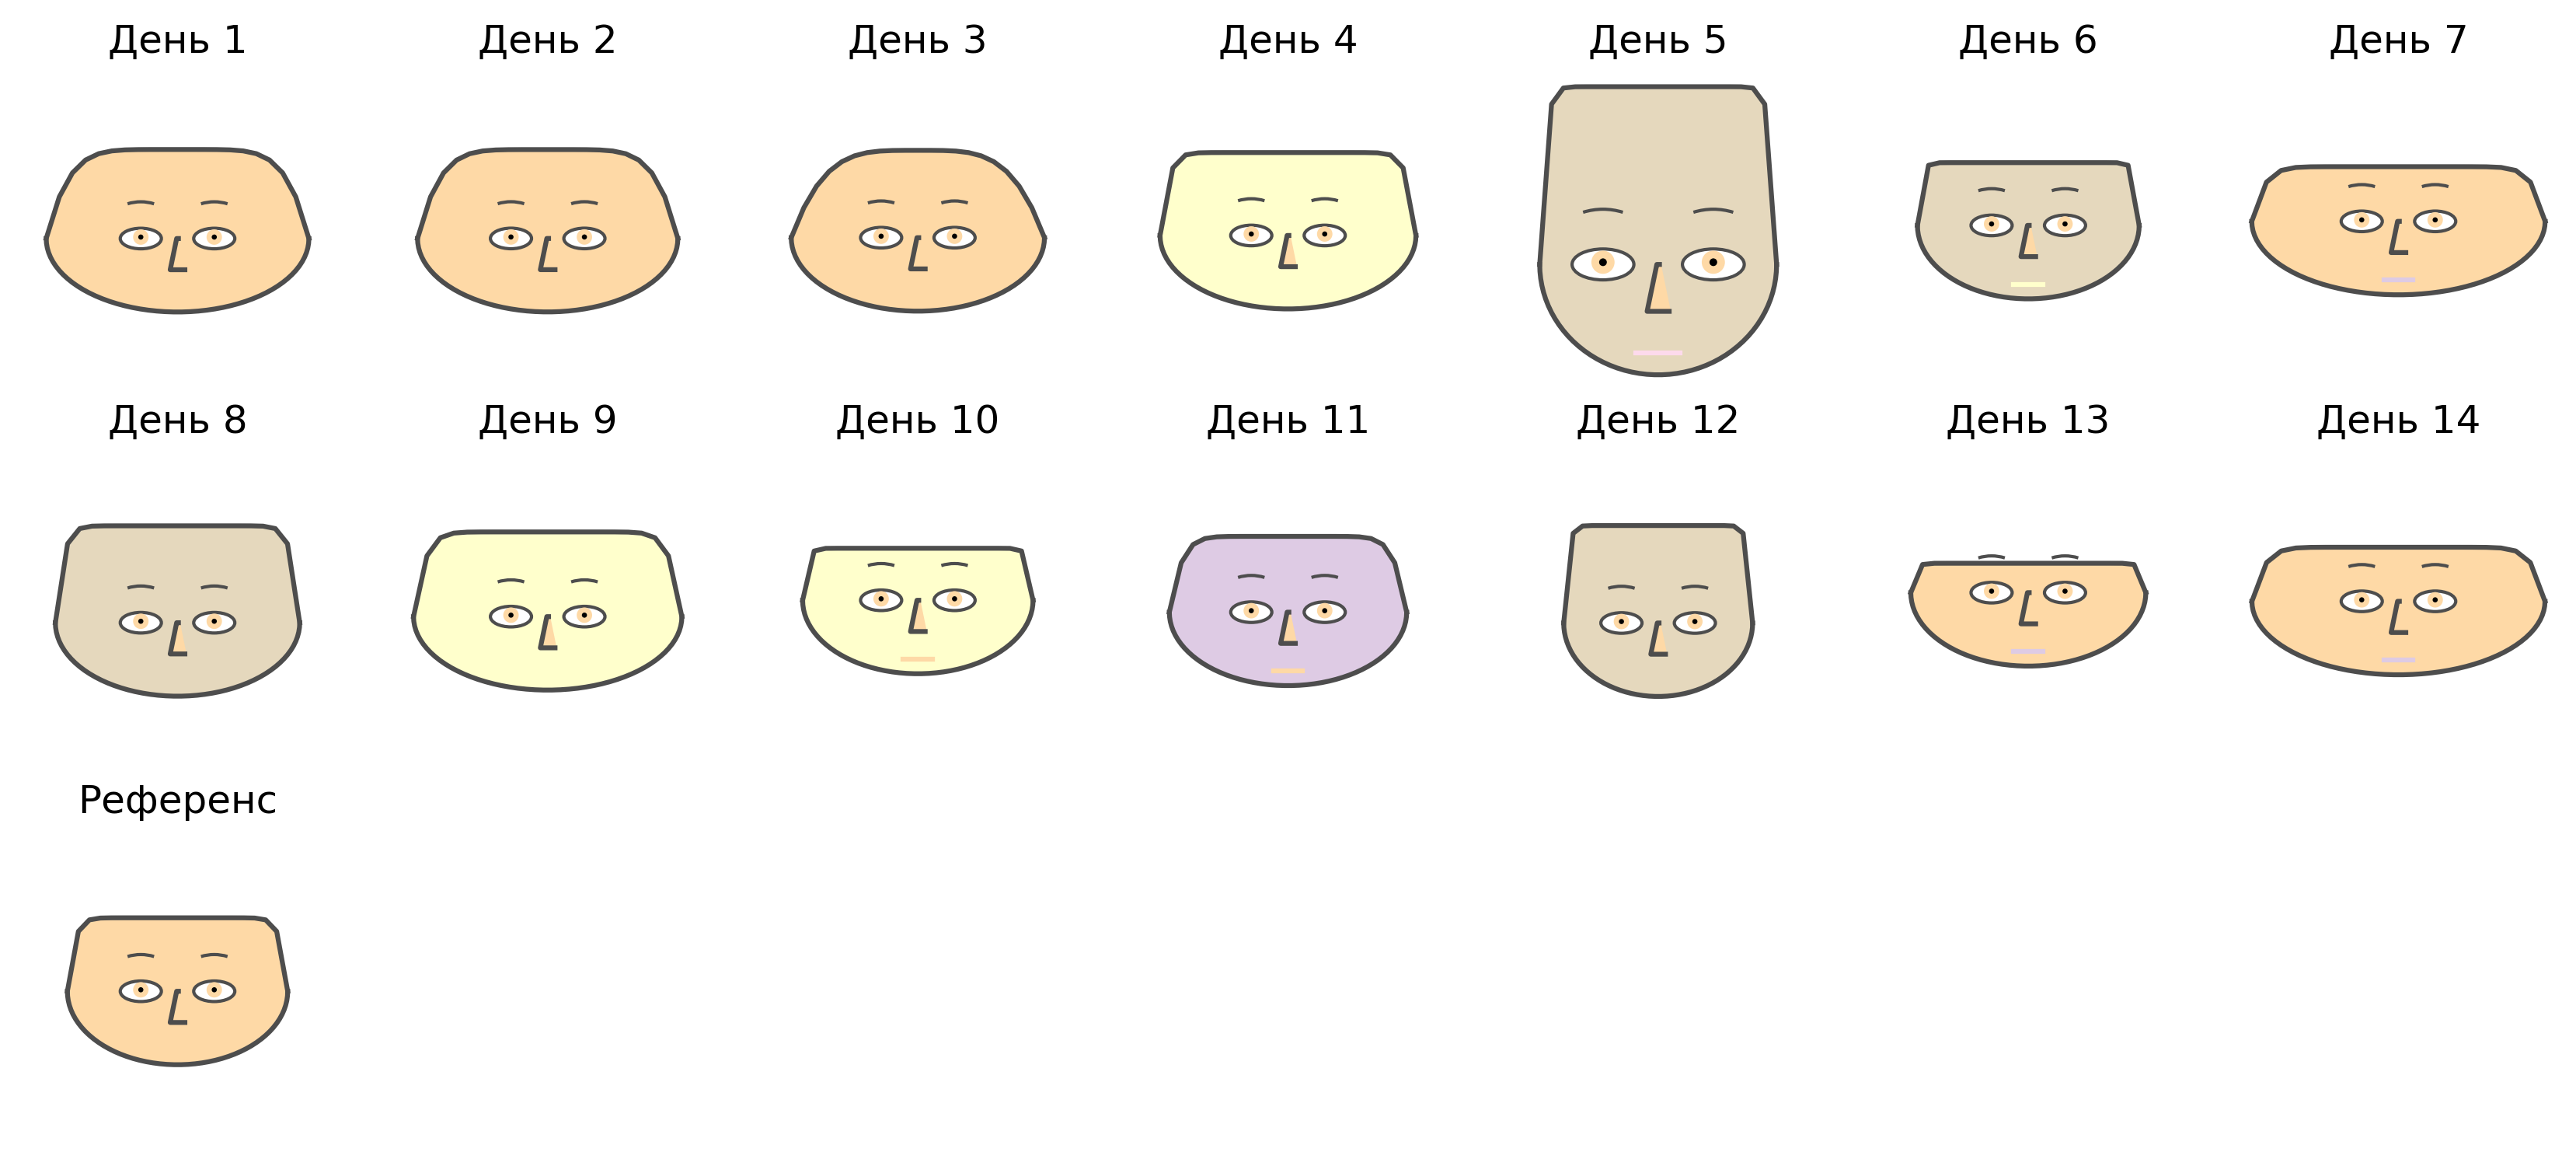

In [233]:
f = plt.figure(dpi=300, figsize=(14, 6))

with_regular = np.array([*useful_l.T, np.full(len(useful_l.T[0]), 0.5)])

fig = chernoff_face(
    data=with_regular,
    color_mapper=matplotlib.cm.Pastel1,
    n_columns=7,
    long_face=False,
    n_rows=3,
    figure=f,
    titles=[*[f"День {i+1}" for i in range(Ndays)], "Референс"]
)

display(fig)

Таблица. Анализ данных с помощью лиц Чернова

| Вопрос | Ответ |
|--------|-------|
| 1. Определение параметров для визуализации с помощью лиц Чернова. | Втечение 14-ти дней каждые 5 минут HVAC оборудование измеряло следующие величины: <br>Lights Power<br>Equipment Power<br>Thermostat Temp<br>Thermostat Heating Setpoint<br>Thermostat Cooling Setpoint<br>VAV REHEAT Damper Position<br>REHEAT COIL Power<br>RETURN OUTLET CO2 Concentration<br>SUPPLY INLET Temperature<br>SUPPLY INLET Mass Flow Rate<br>(названия соответствуют столбцам исходных данных).<br> |
| 2. Схема визуализации Чернова. | Представлена на последнем рисунке. Для построения используются величины, характеризующие корреляцию между температурой термостата, возвращаемой концентрации CO2 и температуры поступающего воздуха, которые кодируются цветом, высотой головы и размером глаз. Так же ниже приведён вариант, соответствующий норме. |
| 3. Определение, в какие дни возникали аномальные ситуации в системе тепловентилирования и кондиционирования. | Как видно из графиков для средних значений и лиц Чернова, в 5 и 6, 9 и 10, и 12 дни. |
| 4. Какие параметры связаны с аномалиями. | Аномалии наблюдаются в отключении электичества для оборудования в 5 и 6 дни. Также о проблемах сигнализируют нарушения корреляции для температуры термостата и возвращаемой концентрации CO2 и температуры поступающего воздуха. |
| 5. Что могло послужит причиной аномалии? (дополнительный необязательный вопрос) | Судя по всему, причиной аномалии служат перебои в электропитании. |